<a href="https://colab.research.google.com/github/SushanthJanga/INFO6105-DSE/blob/main/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract

This dataset provides comprehensive information on various laptops, capturing diverse features and specifications. It is a valuable resource for those interested in exploring and predicting laptop prices based on their characteristics.

This dataset offers a comprehensive overview of laptops from leading brands, presenting essential details such as brand, model name, pricing, specification ratings, processor specifications, RAM and storage configurations, GPU details, display characteristics, operating system, and warranty periods. From high-performance gaming rigs featuring dedicated GPUs like the AMD Radeon RX 6500M or the NVIDIA GeForce RTX 4050 to lightweight ultrabooks optimized for portability and everyday tasks, the dataset encompasses a diverse range of laptops tailored to meet various user needs and preferences. Processors from both AMD and Intel, spanning multiple generations, are featured, providing users with a wide array of options to suit their computing requirements, whether for gaming, productivity, or multimedia consumption.

Display sizes vary across the laptops, ranging from compact 13.3-inch screens to larger 15.6-inch displays, with resolutions ensuring crisp visuals for immersive viewing experiences. Operating systems include Windows 11 OS and macOS, catering to users of both Windows and Apple ecosystems. Furthermore, warranty durations provided offer insights into the post-purchase support offered by different brands, aiding consumers in making informed decisions. This dataset serves as a valuable resource for consumers, researchers, and industry analysts alike, facilitating detailed comparisons, trend analysis, and informed decision-making within the dynamic landscape of the laptop market.



# Importing the required Libraries

In [37]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o
!pip install shap --index-url=https://pypi.python.org/simple/

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
Looking in indexes: https://pypi.python.org/simple/


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
import random, os, sys
from datetime import datetime
import logging
import csv
import optparse
import time
import json
import psutil


# **Importing the Data**

In [39]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/DSE/data.csv')
data=data.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Cleaning Data

First We Check wheather we have any null values in the data.

In [40]:
data.isnull().sum()

brand                0
name                 0
price                0
spec_rating          0
processor            0
CPU                  0
Ram                  0
Ram_type             0
ROM                  0
ROM_type             0
GPU                  0
display_size         0
resolution_width     0
resolution_height    0
OS                   0
warranty             0
dtype: int64

Since there are no null values in the dataset we will encode the categorical featues in our dataset. This is an important to find the best feature in determining about our target variable.

For cleaning the data I have used Ordinal encoder.

The OrdinalEncoder maps each unique category in a categorical feature to a unique integer based on the order they appear in the dataset.

In [41]:
categorical_columns = ['brand', 'processor', 'CPU', 'Ram_type', 'ROM_type', 'GPU', 'OS','Ram','ROM']

ordinal_encoder = OrdinalEncoder()

# Encode categorical variables
data_encoded = ordinal_encoder.fit_transform(data[categorical_columns])

# Concatenate the encoded columns with the original DataFrame
data_encoded_df = pd.DataFrame(data_encoded, columns=[f'{col}_encoded' for col in categorical_columns])

# Concatenate the encoded columns with the original DataFrame
df_encoded = pd.concat([data, data_encoded_df], axis=1)

# Drop the original categorical columns from the DataFrame
df_encoded = df_encoded.drop(columns=categorical_columns)

print(df_encoded.head())  # Display the first few rows of the encoded DataFrame

                                   name  price  spec_rating  display_size  \
0      Victus 15-fb0157AX Gaming Laptop  49900    73.000000          15.6   
1                   15s-fq5007TU Laptop  39900    60.000000          15.6   
2                  One 14 Z8-415 Laptop  26990    69.323529          14.0   
3  Yoga Slim 6 14IAP8 82WU0095IN Laptop  59729    66.000000          14.0   
4       MacBook Air 2020 MGND3HN Laptop  69990    69.323529          13.3   

   resolution_width  resolution_height  warranty  brand_encoded  \
0            1920.0             1080.0         1            9.0   
1            1920.0             1080.0         1            9.0   
2            1920.0             1080.0         1            1.0   
3            2240.0             1400.0         1           14.0   
4            2560.0             1600.0         1            2.0   

   processor_encoded  CPU_encoded  Ram_type_encoded  ROM_type_encoded  \
0              105.0         19.0               2.0          

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              893 non-null    object 
 1   name               893 non-null    object 
 2   price              893 non-null    int64  
 3   spec_rating        893 non-null    float64
 4   processor          893 non-null    object 
 5   CPU                893 non-null    object 
 6   Ram                893 non-null    object 
 7   Ram_type           893 non-null    object 
 8   ROM                893 non-null    object 
 9   ROM_type           893 non-null    object 
 10  GPU                893 non-null    object 
 11  display_size       893 non-null    float64
 12  resolution_width   893 non-null    float64
 13  resolution_height  893 non-null    float64
 14  OS                 893 non-null    object 
 15  warranty           893 non-null    int64  
dtypes: float64(4), int64(2), o

**Now we are going to Plot QQ graphs.**

Quantile-Quantile (QQ) plots are utilized to visually inspect whether a dataset adheres to a specific probability distribution, notably the normal distribution. They facilitate comparison between the quantiles of the dataset and those of a theoretical distribution, typically through a straight line if the dataset conforms to the specified distribution. QQ plots are invaluable for identifying deviations from normality, highlighting skewness, kurtosis, and any other departure from expected distributional characteristics. Particularly relevant in statistical modeling, QQ plots aid in assumption checking by assessing whether the underlying assumptions, such as normality, hold true for the dataset. Moreover, they serve as a means of model validation, allowing comparison of model residuals against expected distributions, thereby enhancing the reliability of statistical analyses and modeling endeavors.

<Figure size 800x500 with 0 Axes>

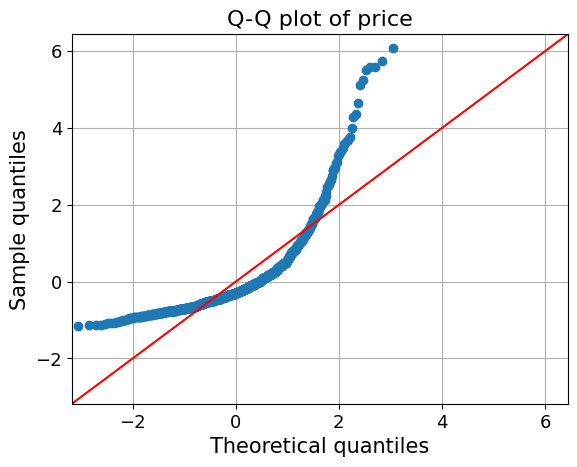

<Figure size 800x500 with 0 Axes>

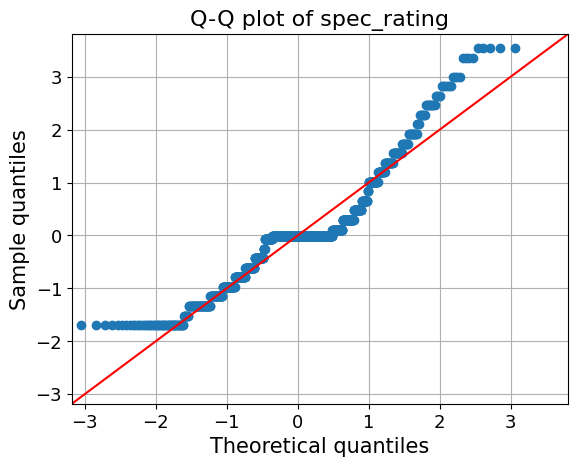

<Figure size 800x500 with 0 Axes>

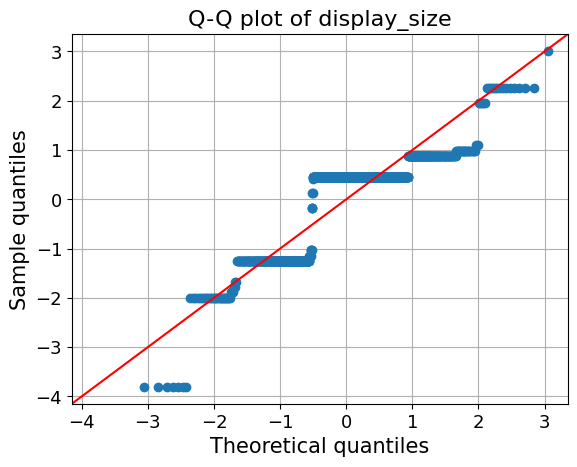

<Figure size 800x500 with 0 Axes>

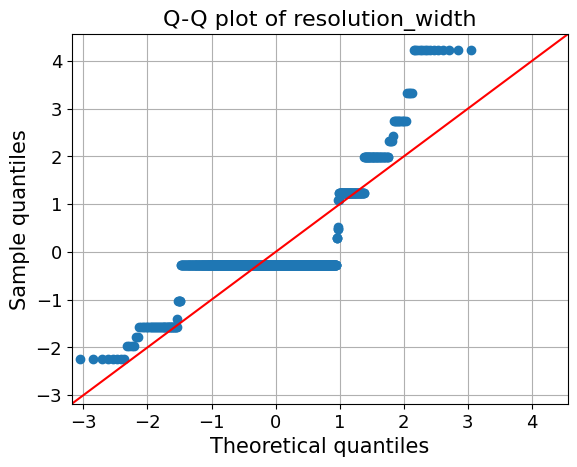

<Figure size 800x500 with 0 Axes>

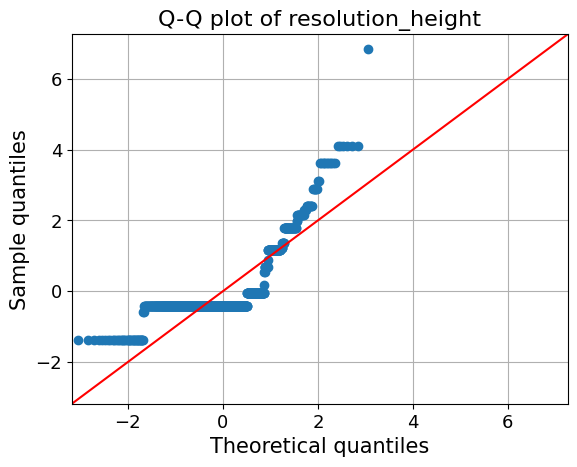

<Figure size 800x500 with 0 Axes>

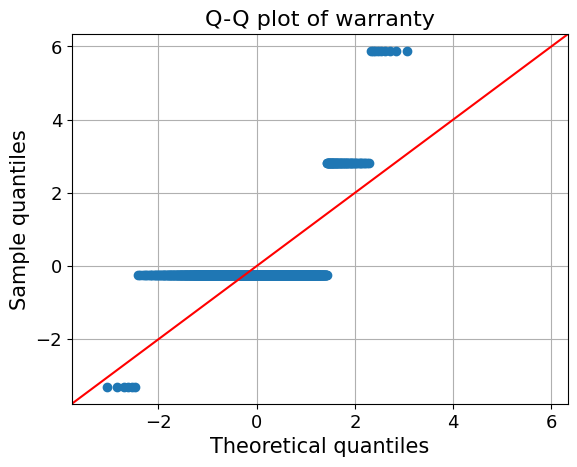

<Figure size 800x500 with 0 Axes>

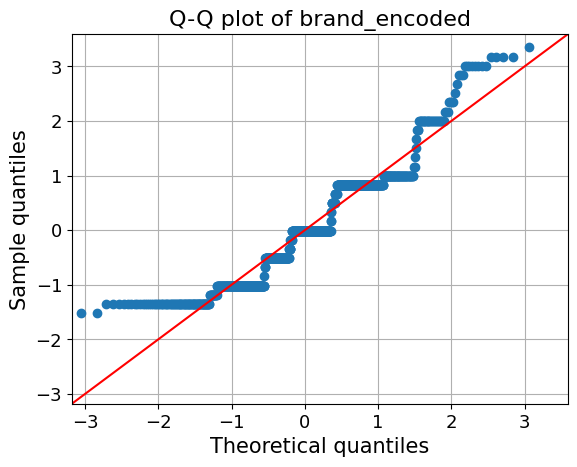

<Figure size 800x500 with 0 Axes>

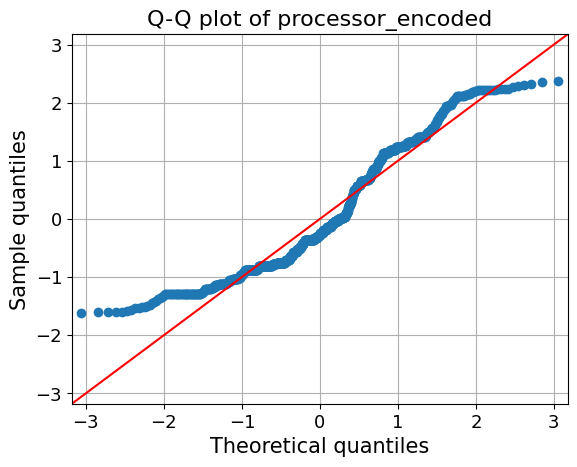

<Figure size 800x500 with 0 Axes>

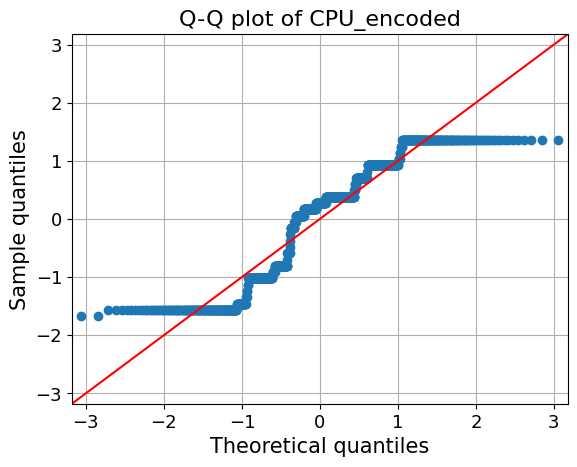

<Figure size 800x500 with 0 Axes>

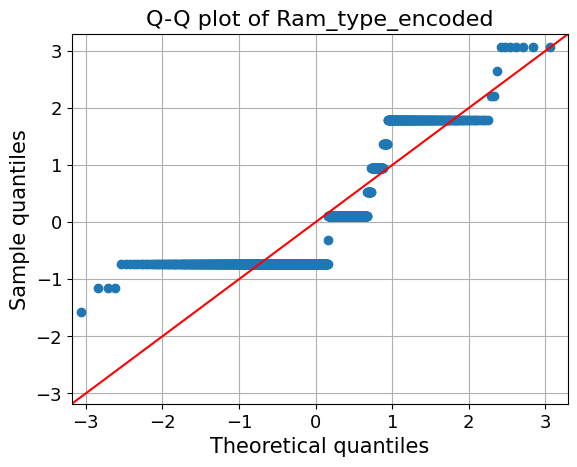

<Figure size 800x500 with 0 Axes>

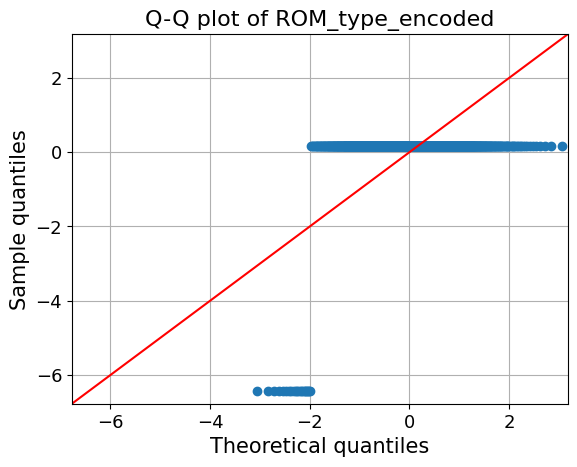

<Figure size 800x500 with 0 Axes>

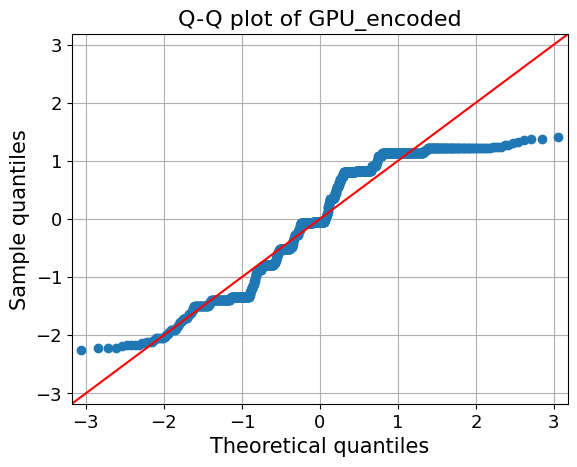

<Figure size 800x500 with 0 Axes>

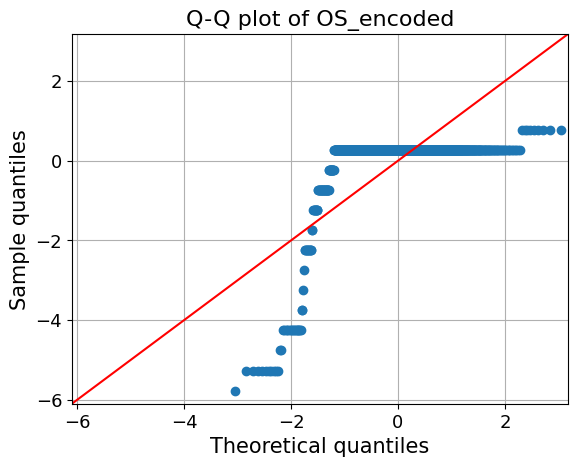

<Figure size 800x500 with 0 Axes>

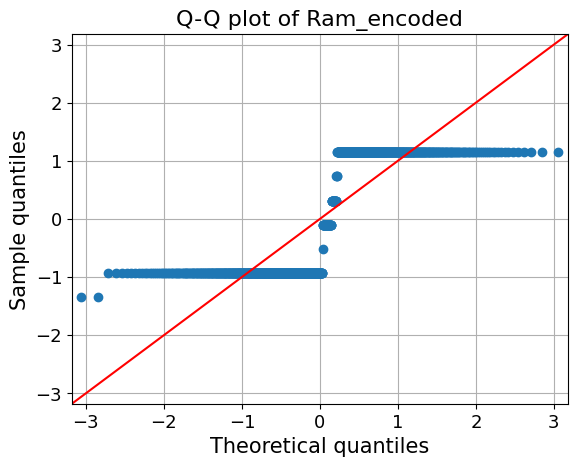

<Figure size 800x500 with 0 Axes>

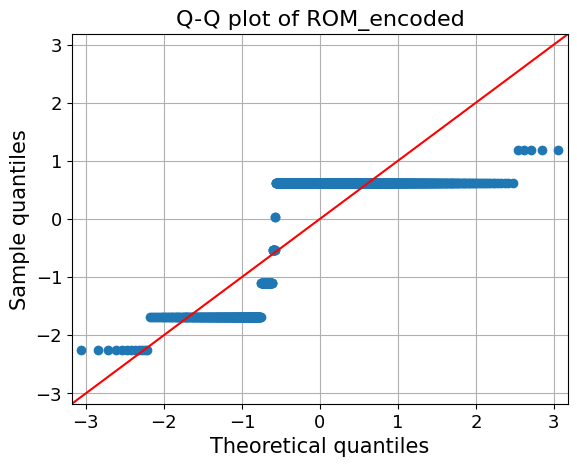

In [43]:
from statsmodels.graphics.gofplots import qqplot

data_norm=df_encoded.drop(['name'],axis=1,inplace=False)
for c in data_norm.columns[:]:
    plt.figure(figsize=(8, 5))
    fig = qqplot(data_norm[c], line="45", fit="True")
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel("Theoretical quantiles", fontsize=15)
    plt.ylabel("Sample quantiles", fontsize=15)
    plt.title("Q-Q plot of {}".format(c), fontsize=16)
    plt.grid(True)
    plt.show()

Looking from the Q-Q plots above, we can say that all the plots have binomial distribution apart from price which has a skewed distribution.

And there are few outliners in few predictor variables like in display_size, resolution_height.


In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split

X = data_norm.drop('price', axis=1)  # Features
y = data_norm['price']  # Target variable

#Splitting Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xtrain_stats=X_train.describe()
xtest_stats=X_test.describe()
ytrain_stats=y_train.describe()
ytest_stats=y_test.describe()

print(xtrain_stats)
print(xtest_stats)
print(ytrain_stats)
print(ytest_stats)

       spec_rating  display_size  resolution_width  resolution_height  \
count   714.000000    714.000000        714.000000          714.00000   
mean     69.450610     15.179132       2033.271709         1219.07563   
std       5.483394      0.942364        423.895627          327.78142   
min      60.000000     11.600000       1080.000000          768.00000   
25%      66.000000     14.000000       1920.000000         1080.00000   
50%      69.323529     15.600000       1920.000000         1080.00000   
75%      71.000000     15.600000       1920.000000         1200.00000   
max      89.000000     18.000000       3840.000000         3456.00000   

         warranty  brand_encoded  processor_encoded  CPU_encoded  \
count  714.000000     714.000000         714.000000   714.000000   
mean     1.078431       9.037815          74.355742    15.390756   
std      0.321305       5.792094          45.838298     9.274071   
min      0.000000       0.000000           1.000000     0.000000   
25

Splitting data into training and testing sets is crucial in machine learning for several reasons. Firstly, it allows us to assess the performance of our model on unseen data, which provides a more accurate estimate of how well the model will generalize to new, unseen data in the future. This helps to detect overfitting, where the model performs well on the training data but poorly on new data. Secondly, by evaluating the model on a separate test set, we can obtain unbiased estimates of the model's performance metrics, such as accuracy, precision, recall, or F1-score. This ensures that our evaluation metrics are not overly optimistic due to the model seeing the test data during training. Additionally, splitting the data helps to simulate real-world scenarios where the model encounters new instances it hasn't seen before. This ensures that our model is robust and reliable when deployed in production environments. Overall, splitting data into training and testing sets is a fundamental practice in machine learning to validate the performance and generalization ability of our models.

The mean values of features in both training and testing sets are close, it suggests consistency in data distribution and potential for model generalization. Similar means indicate that patterns learned from training data are likely applicable to unseen data. Divergent means may signal sampling bias or data leakage, risking poor model performance. Consistency in mean values is one aspect of assessing model reliability and generalization ability.







# Feature Selection

We are going to use 3 methods for finding out the best features.

The three methods that we are going to use are


1.   Correlation Analyis
2.   Recursive Feature Elimination
3.   Random Forest Feature Importance



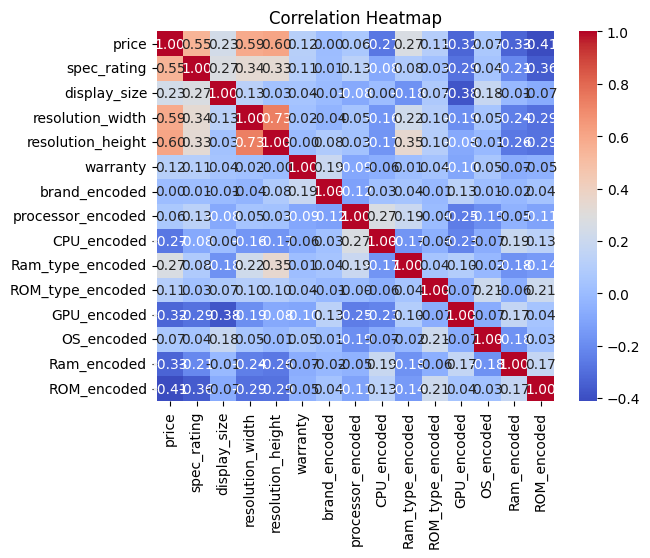

Selected features using correlation analysis: ['price', 'spec_rating', 'display_size', 'resolution_width', 'resolution_height', 'CPU_encoded', 'Ram_type_encoded', 'GPU_encoded', 'Ram_encoded', 'ROM_encoded']
Selected features using RFE: ['warranty', 'ROM_type_encoded', 'ROM_encoded']
Selected features using Random Forest feature importance: ['spec_rating', 'resolution_width', 'GPU_encoded']


In [44]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Display the correlation heatmap
sns.heatmap(data_norm.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Method 1: Correlation Analysis
correlations = data_norm.corr()['price'].abs()
selected_features_corr = correlations[correlations >= 0.2].index.tolist()
print("Selected features using correlation analysis:", selected_features_corr)

# Method 2: Recursive Feature Elimination (RFE)
X = data_norm.drop('price', axis=1)
y = data_norm['price']

model = LinearRegression()
rfe = RFE(model, n_features_to_select=3)
fit = rfe.fit(X, y)
selected_features_rfe = X.columns[fit.support_].tolist()
print("Selected features using RFE:", selected_features_rfe)

# Method 3: Random Forest Feature Importance
rf_model = RandomForestRegressor()
rf_model.fit(X, y)
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
selected_features_rf = feature_importance.head(3).index.tolist()
print("Selected features using Random Forest feature importance:", selected_features_rf)


# Modelling

Here we are using Amazon H20 for Auto ML. The reason for doing the Auto ML is so that we can check the data reading and model implementation for the dataset.

AutoML, or Automated Machine Learning, streamlines the model development process by automating various tasks, including feature engineering, model selection, hyperparameter tuning, and model evaluation. This approach significantly reduces the time and expertise required for building robust machine learning models, making it accessible to a wider range of users. AutoML platforms employ sophisticated algorithms and optimization techniques to iteratively explore the model space, identifying the most effective combination of features and algorithms for the given dataset. By automating repetitive and time-consuming tasks, AutoML accelerates the deployment of machine learning solutions, empowers domain experts with limited machine learning knowledge to leverage advanced analytics, and fosters innovation by enabling rapid experimentation and iteration in model development.

From the AutoML we will find the best model and check how our data is performing in the model.

In [46]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 4 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,20 days
H2O_cluster_name:,H2O_from_python_unknownUser_0xhic1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.024 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [47]:
df = h2o.H2OFrame(
    df_encoded
)

pct_rows = 0.80  # Setting up the data split between training and test dataset.
df_train, df_test = df.split_frame([pct_rows])

#Display all columns in X
X=df.columns
print(X)

#Seperate Dependent variable from Independent variable
y_numeric ='price'
X.remove(y_numeric)
print(X)

# Set up AutoML
aml = H2OAutoML(max_models=10, seed=1234, sort_metric="MAE", project_name = "random_split")

aml.train(x=X,y=y_numeric,training_frame=df_train)

print(aml.leaderboard)# Leaderboard showing the performance of different models on the dataset.

best_model = aml.leader
best_model.model_performance(df_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
['name', 'price', 'spec_rating', 'display_size', 'resolution_width', 'resolution_height', 'warranty', 'brand_encoded', 'processor_encoded', 'CPU_encoded', 'Ram_type_encoded', 'ROM_type_encoded', 'GPU_encoded', 'OS_encoded', 'Ram_encoded', 'ROM_encoded']
['name', 'spec_rating', 'display_size', 'resolution_width', 'resolution_height', 'warranty', 'brand_encoded', 'processor_encoded', 'CPU_encoded', 'Ram_type_encoded', 'ROM_type_encoded', 'GPU_encoded', 'OS_encoded', 'Ram_encoded', 'ROM_encoded']
AutoML progress: |
19:59:01.843: New models will be added to existing leaderboard random_split@@price (leaderboard frame=null) with already 12 models.
20:00:13.70: StackedEnsemble_BestOfFamily_2_AutoML_2_20240402_195901 [StackedEnsemble best_of_family_xglm (built with AUTO metalearner, using top model from each algorithm type)] failed: water.exceptions.H2OIllegalArgumentException: Base models are incons

ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 146816765.2483748
RMSE: 12116.796822938593
MAE: 5986.217577281283
RMSLE: 0.10991510923571947
Mean Residual Deviance: 146816765.2483748
R^2: 0.963418924980946
Null degrees of freedom: 178
Residual degrees of freedom: 174
Null deviance: 721383540725.8911
Residual deviance: 26280200979.459087
AIC: 3886.0205560313057

From the Auto ML we have obtained that the Stack Ensemble is the best model for prediction.

The best model was choosen by their rsme score. Having a low rsme score means the model is the best performing. Here Stack Ensemble has an RSME of 6740.05880818311

In [48]:
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
import matplotlib.cbook

warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

In [49]:
if best_model.algo in [
    "gbm",
    "drf",
    "xrt",
    "xgboost",
]:  # Importance of all the variables in GBM algorithm.
    best_model.varimp_plot()

In [61]:
import statsmodels.api as sm

model = sm.OLS(data['price'], data[['spec_rating', 'display_size', 'resolution_width', 'resolution_height', 'warranty']]).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.778
Model:                            OLS   Adj. R-squared (uncentered):              0.777
Method:                 Least Squares   F-statistic:                              623.6
Date:                Tue, 02 Apr 2024   Prob (F-statistic):                   1.53e-287
Time:                        20:48:13   Log-Likelihood:                         -10879.
No. Observations:                 893   AIC:                                  2.177e+04
Df Residuals:                     888   BIC:                                  2.179e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
spec_rating        1672.9347    291.794      5.733      0.000    1100.249    2245.620
display_size      -1.182e+04   1234.729     -9.573      0.000   -1.42e+04   -9396.879
resolution_width     32.0482      5.566      5.757      0.000      21.123      42.973
resolution_height    59.3747      7.247      8.193      0.000      45.152      73.597
warranty           6384.2728   4866.433      1.312      0.190   -3166.778    1.59e+04
==============================================================================
Omnibus:                      464.834   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4111.207
Skew:                           2.205   Prob(JB):                         0.00
Kurtosis:                      12.541   Cond. No.                     7.44e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 7.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model seems to fit the data well (high R-squared), but some diagnostics suggest potential issues with normality and multicollinearity. The results provide insights into how different factors like specifications, size, resolution, and warranty affect product price.

Regarding Relation Ship Significance:

Conventionally, a p-value less than 0.05 is considered statistically significant.

In this case:

spec_rating, display_size, resolution_width, resolution_height, and warranty all have p-values < 0.05, indicating statistically significant relationships with price. We can be confident that these predictors are not just random noise and likely have a genuine impact on price.

In [51]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X=df_encoded.drop(['price','name'],axis=1, inplace=False)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

              feature         VIF
0         spec_rating  180.932876
1        display_size  201.150719
2    resolution_width   55.688053
3   resolution_height   37.677474
4            warranty   12.755605
5       brand_encoded    3.691652
6   processor_encoded    4.748187
7         CPU_encoded    4.698263
8    Ram_type_encoded    4.480522
9    ROM_type_encoded   48.128259
10        GPU_encoded    6.663495
11         OS_encoded   39.387514
12        Ram_encoded    3.431278
13        ROM_encoded    7.475903


Here we are checking for multicolinearity.

Based on the VIF (Variance Inflation Factor) values that are present, it appears we have multicollinearity in our data, particularly between some of the feature variables.

Here's what the VIF values tell us:

VIF > 10: Indicates potential multicollinearity. VIF > 100: Indicates strong multicollinearity, requiring action.

In our case:

spec_rating and display_size have VIF values > 100, suggesting strong multicollinearity. resolution_width and resolution_height have VIF values > 10, suggesting moderate multicollinearity. warranty has a VIF < 10, indicating no significant multicollinearity.


**Now since we have seen some multicolinearity we are going to do regularization.**

# Regularization
In this Section, we will be using the GLM model to check if regularization is helping us to improve the accuracy and reduce overfitting.

*   Ridge and Lasso are regularization techniques used in linear regression to prevent overfitting and improve the model's generalization ability.
*   Ridge regularization adds a penalty term to the least-squares objective function of the linear regression model. This penalty term is proportional to the square of the magnitude of the coefficients of the model, which shrinks the coefficients towards zero. The strength of the penalty is controlled by a hyperparameter called the regularization parameter, which needs to be tuned to achieve the best performance. Ridge regularization is particularly useful when there are many input variables that are correlated with each other, as it can help to reduce the variance of the model by reducing the effect of these correlated variables.
*   Lasso regularization is similar to Ridge regularization, but instead of adding a penalty term proportional to the square of the coefficients, it adds a penalty term proportional to the absolute value of the coefficients. This penalty term can set some coefficients to exactly zero, which makes Lasso regularization a useful method for feature selection. By setting some coefficients to zero, Lasso can effectively remove irrelevant variables from the model, which can lead to a simpler and more interpretable model.
*   The main difference between Ridge and Lasso regularization is the type of penalty function used. Ridge uses L2 regularization, while Lasso uses L1 regularization. L2 regularization tends to distribute the penalty evenly across all coefficients, while L1 regularization tends to concentrate the penalty on a smaller subset of the most important coefficients. Which method to use depends on the specific problem and the properties of the input variables.






In [52]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

price_glm = H2OGeneralizedLinearEstimator(
    family="gaussian", lambda_=0, compute_p_values=True, nfolds=5
)  # Elastic Net Regularization
price_glm_regularization_ridge = H2OGeneralizedLinearEstimator(
    family="gaussian", alpha=0, nfolds=5
)  # RIDGE Regularization
price_glm_regularization_lasso = H2OGeneralizedLinearEstimator(
    family="gaussian", alpha=1, nfolds=5
)  # LASSO Regularization
price_glm_regularization_lamba_search = H2OGeneralizedLinearEstimator(
    lambda_search=True
)  # Lambda Search

X=df.columns
y_numeric ='price'
X.remove(y_numeric)

price_glm_regularization_ridge.train(x=X, y=y_numeric, training_frame=df_train)

price_glm_regularization_lasso.train(x=X, y=y_numeric, training_frame=df_train)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,Lasso (lambda = 3657.9 ),829,10,1,py_477_sid_992d
,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
aic,3437.4326,53.551544,3443.122,3469.3513,3506.0564,3390.1523,3378.4812
loglikelihood,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mae,24201.371,2891.4656,23961.62,19992.145,25992.434,27643.037,23417.625
mean_residual_deviance,1489688190.0000000,439568352.0000000,1437330690.0000000,896037820.0000000,1884556800.0000000,1954567810.0000000,1275947650.0000000
mse,1489688190.0000000,439568352.0000000,1437330690.0000000,896037820.0000000,1884556800.0000000,1954567810.0000000,1275947650.0000000
null_deviance,519685800000.0000000,141473890000.0000000,590621570000.0000000,317076865000.0000000,599082730000.0000000,660512440000.0000000,431135392000.0000000
r2,0.5825474,0.0420121,0.6513586,0.5501206,0.5468700,0.5817144,0.5826729
residual_deviance,212045119000.0000000,60424933000.0000000,205538296000.0000000,131717562000.0000000,271376171000.0000000,271684927000.0000000,179908608000.0000000


The regularization helped as we can see from both model that the mean squraed error has significantly improved from before.

The Ridge regularization method has improved MSE mean more.

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
XGBoost_6_AutoML_2_20240402_195901,7961.54,6.33862e+07,5374.79,0.111835,6.33862e+07,1645,0.013113,XGBoost
XGBoost_5_AutoML_2_20240402_195901,8223.78,6.76305e+07,4548.67,0.095886,6.76305e+07,1610,0.027348,XGBoost
GBM_6_AutoML_2_20240402_195901,10571.5,1.11756e+08,4331.7,0.147785,1.11756e+08,738,0.027123,GBM
GBM_7_AutoML_2_20240402_195901,11309.8,1.27911e+08,4175.95,0.150517,1.27911e+08,679,0.032214,GBM
StackedEnsemble_AllModels_1_AutoML_1_20240402_190047,12116.8,1.46817e+08,5986.22,0.109915,1.46817e+08,1191,0.093636,StackedEnsemble
XGBoost_3_AutoML_1_20240402_190047,12164.8,1.47981e+08,6320.12,0.121095,1.47981e+08,652,0.013423,XGBoost
XGBoost_2_AutoML_1_20240402_190047,12165.5,1.47999e+08,6279.43,0.127087,1.47999e+08,1151,0.020701,XGBoost
GBM_8_AutoML_2_20240402_195901,12236.3,1.49728e+08,4682.54,0.137741,1.49728e+08,776,0.025546,GBM
StackedEnsemble_BestOfFamily_1_AutoML_1_20240402_190047,12402.6,1.53825e+08,6231.39,0.115314,1.53825e+08,1188,0.078813,StackedEnsemble
XRT_2_AutoML_2_20240402_195901,13358,1.78437e+08,7545.83,0.135247,1.78437e+08,3201,0.044664,DRF


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

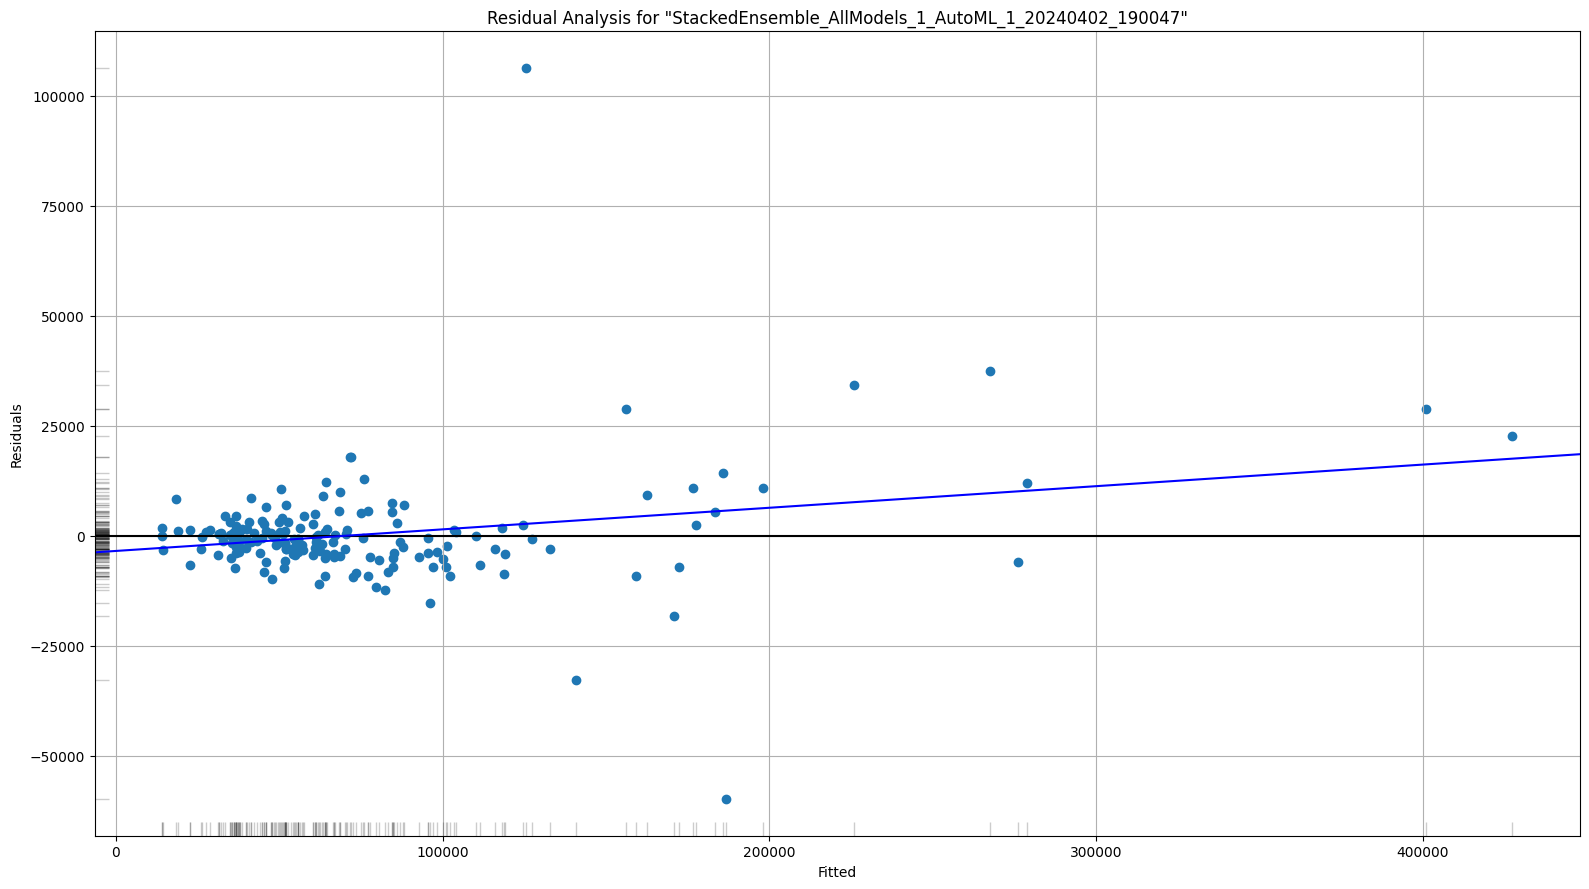

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

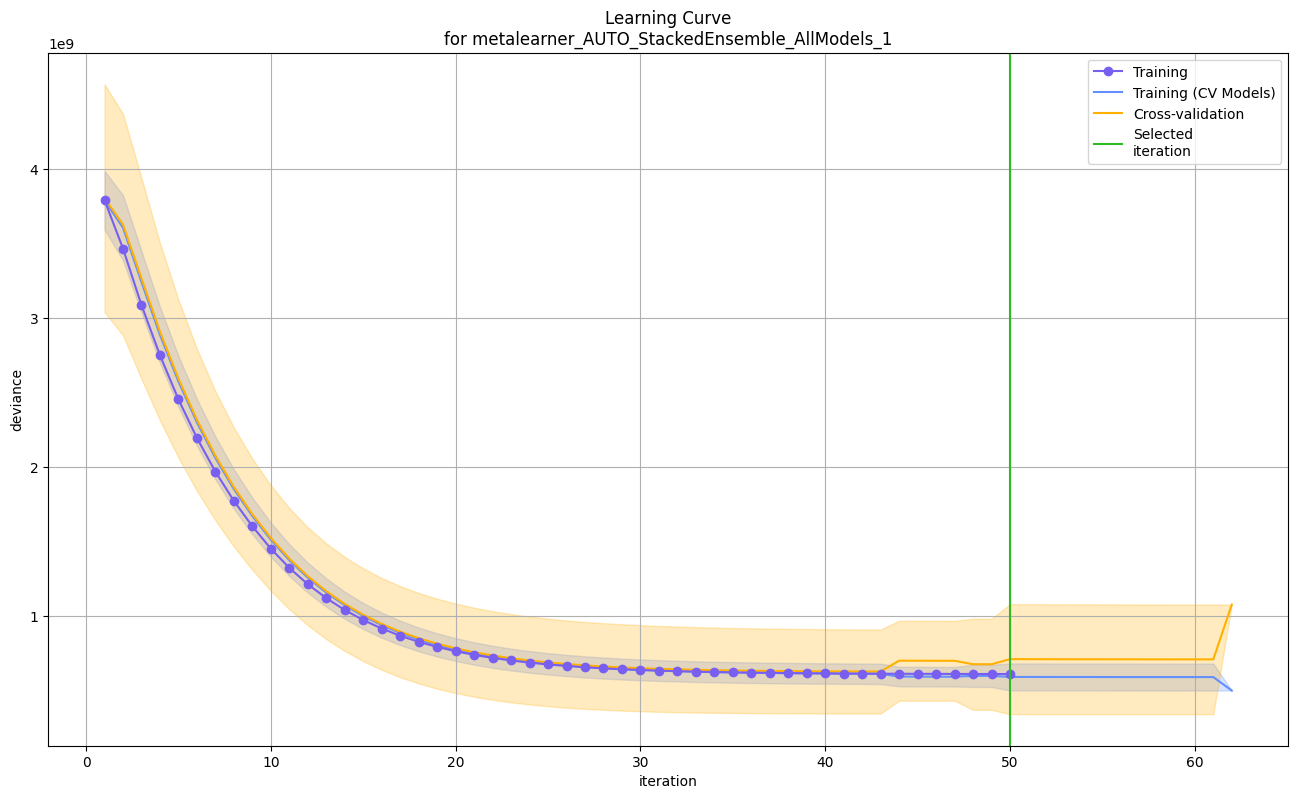

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

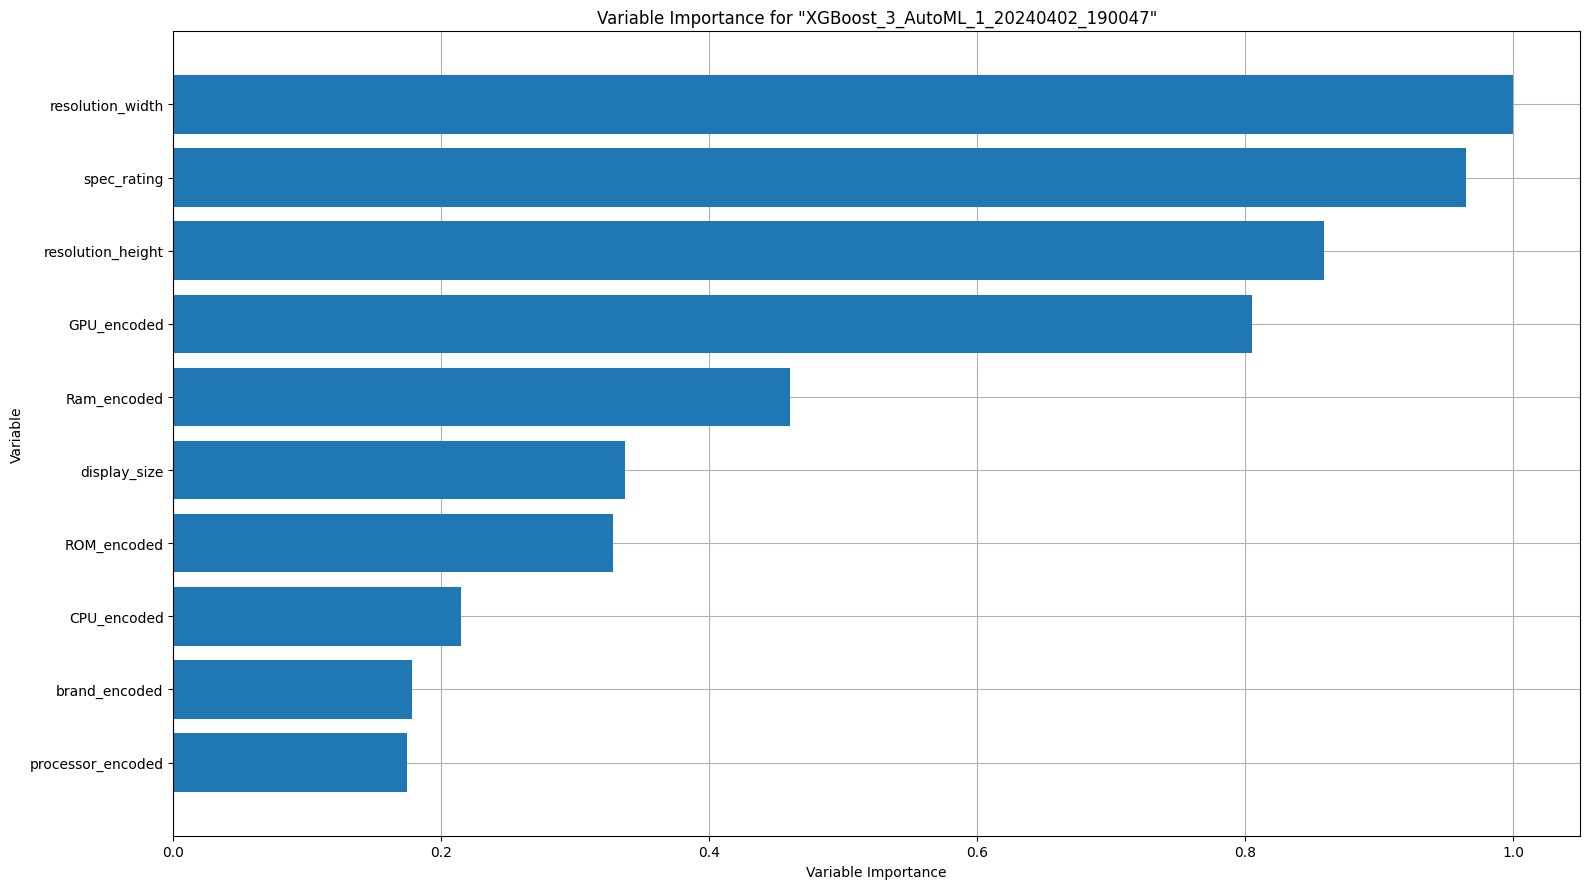

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

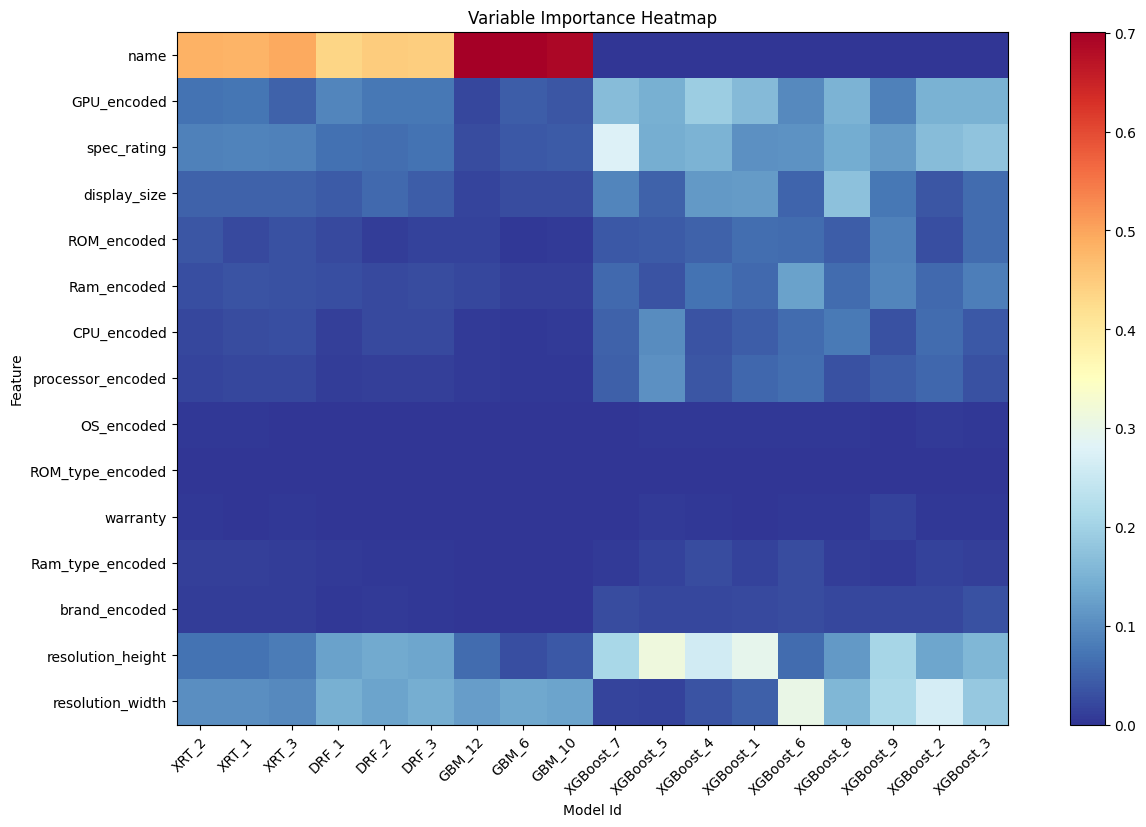

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

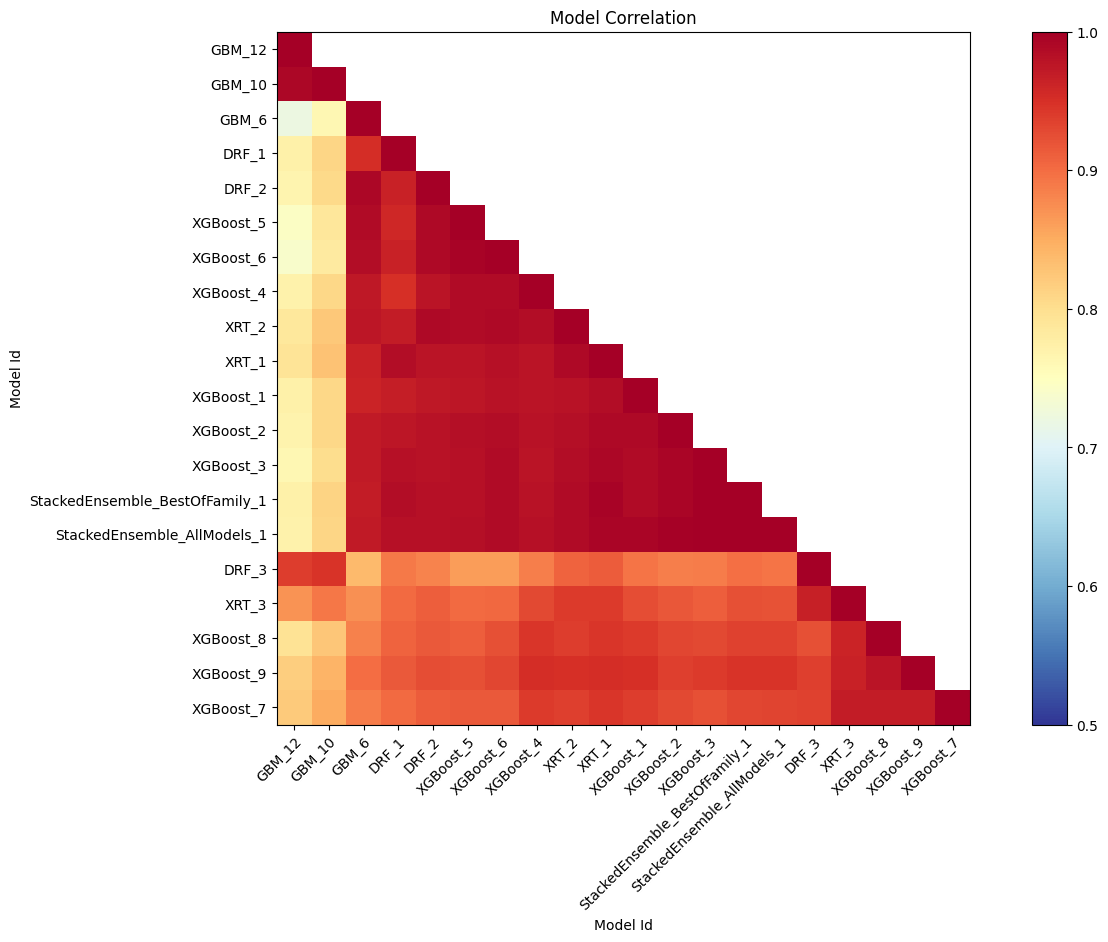

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

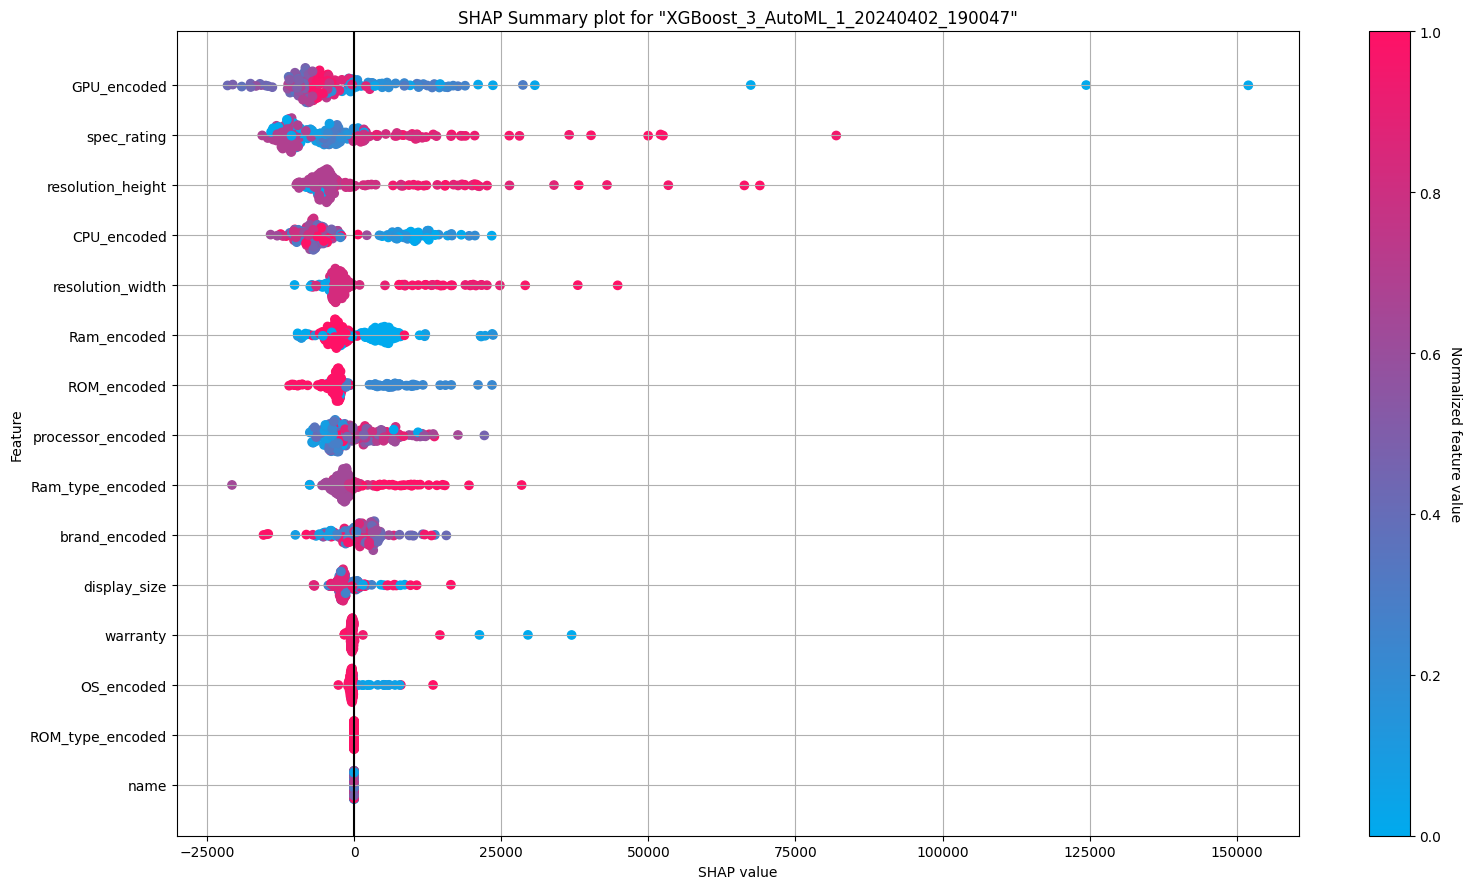

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

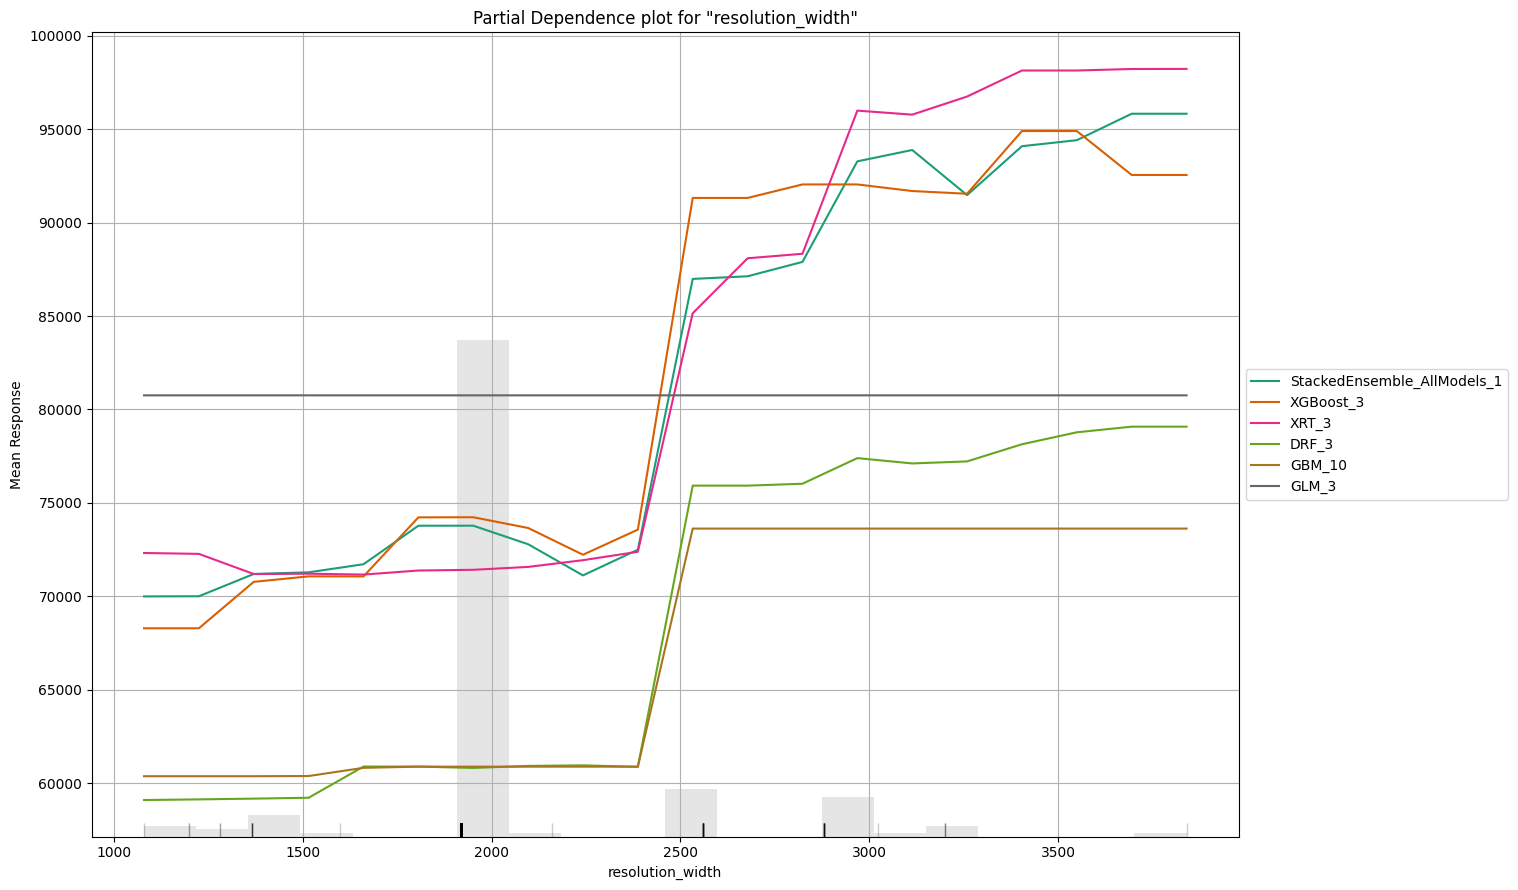

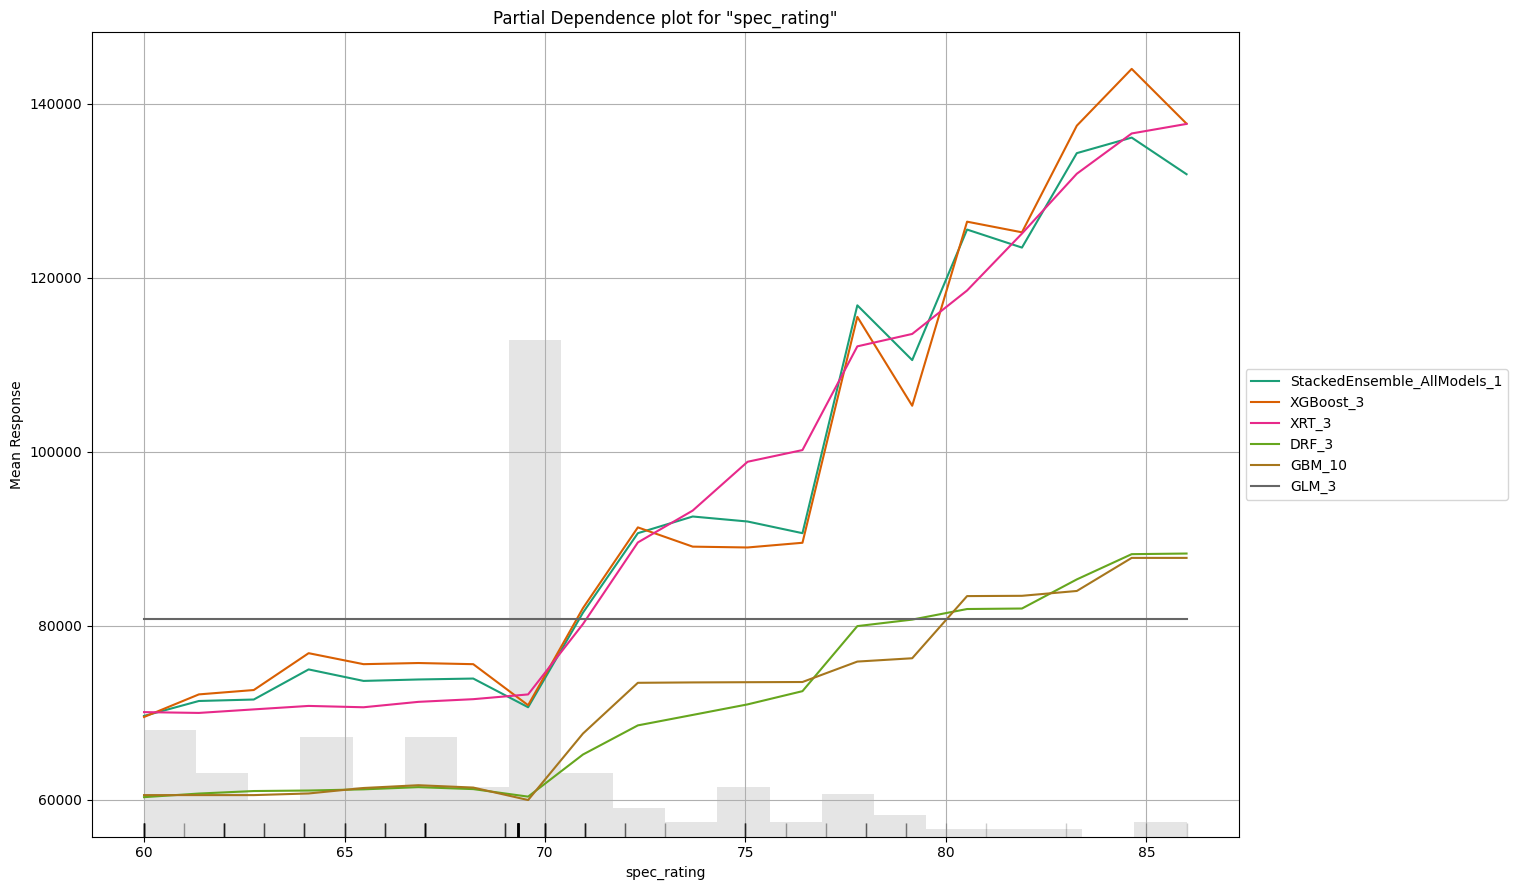

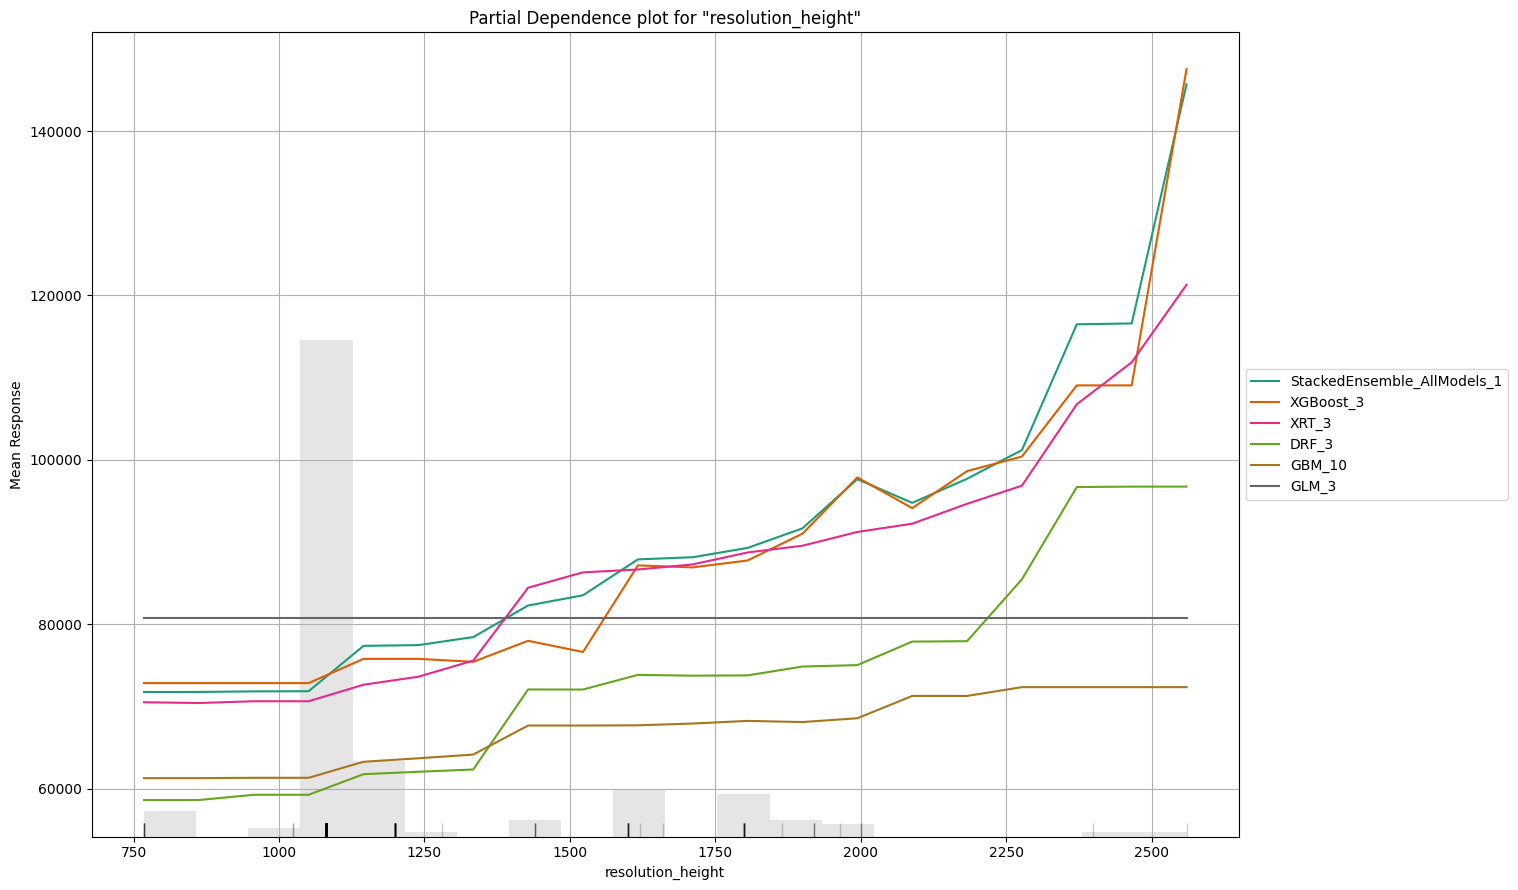

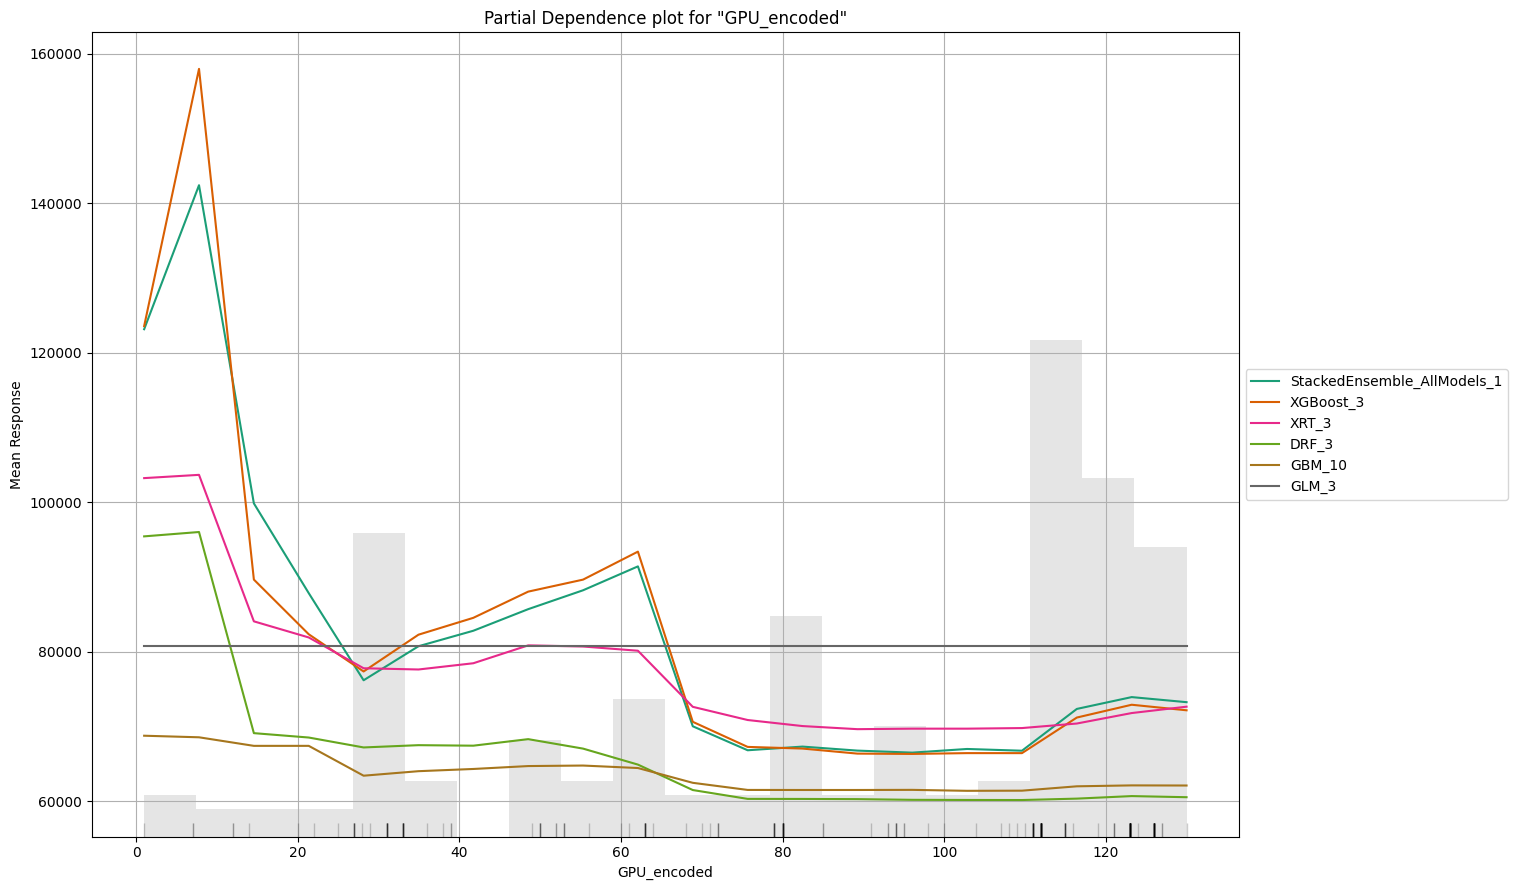

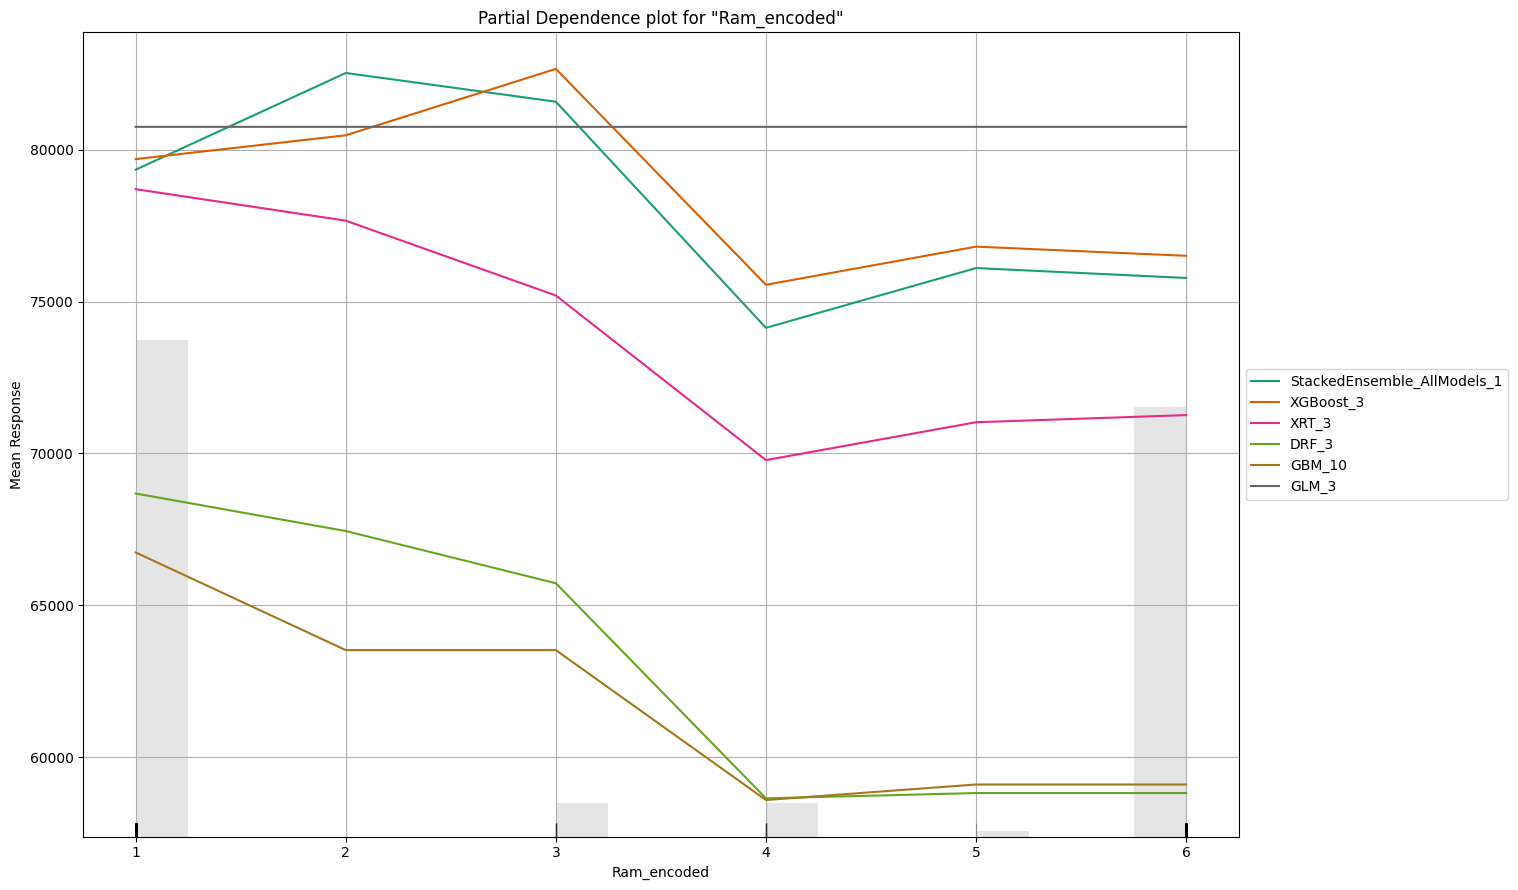

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

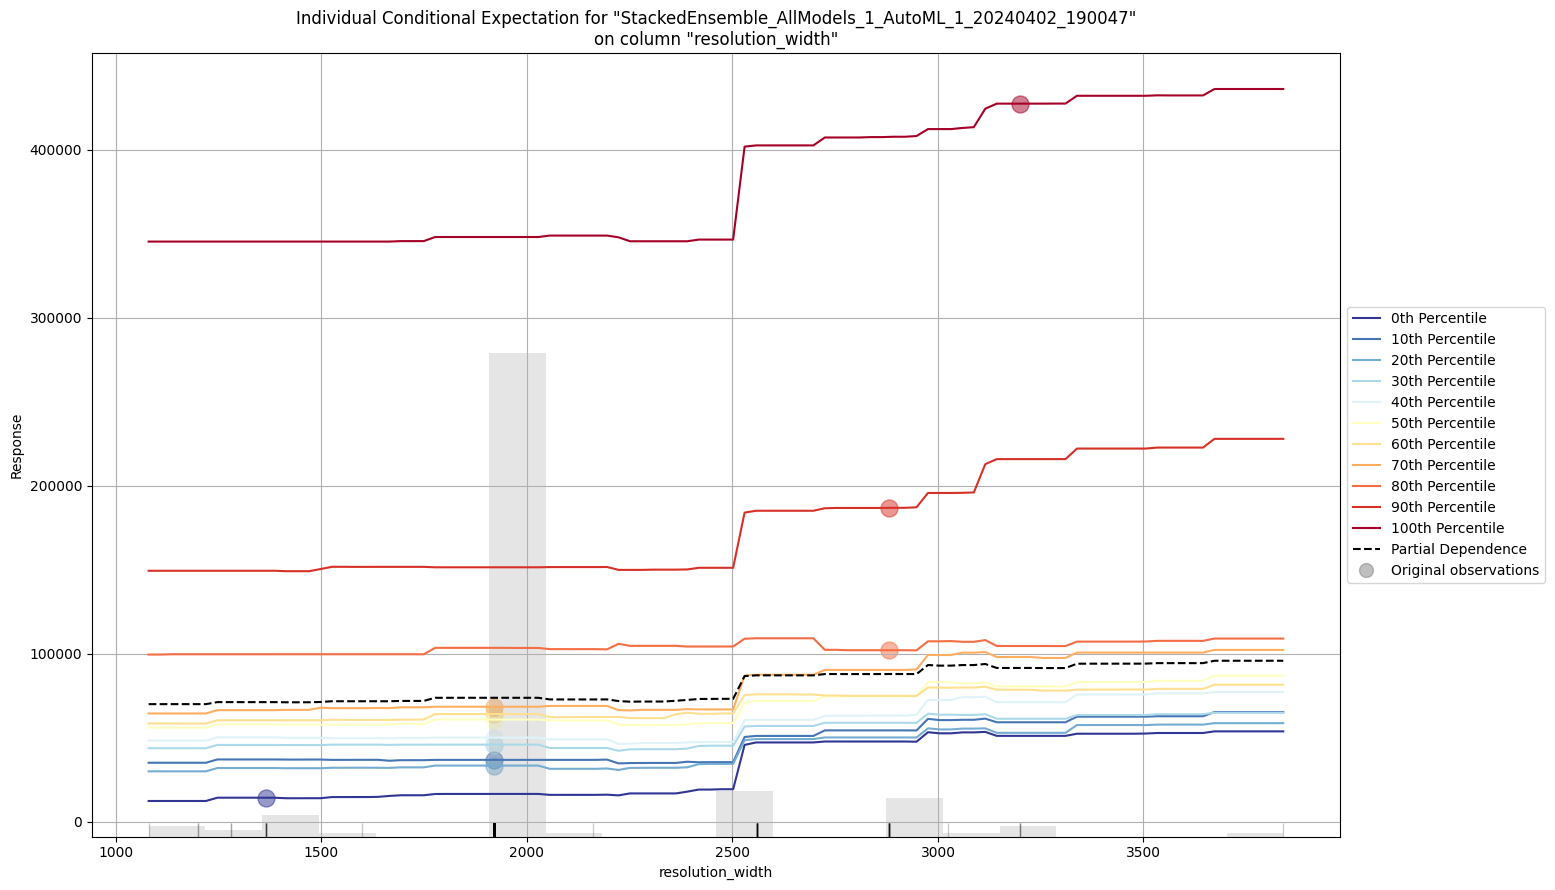

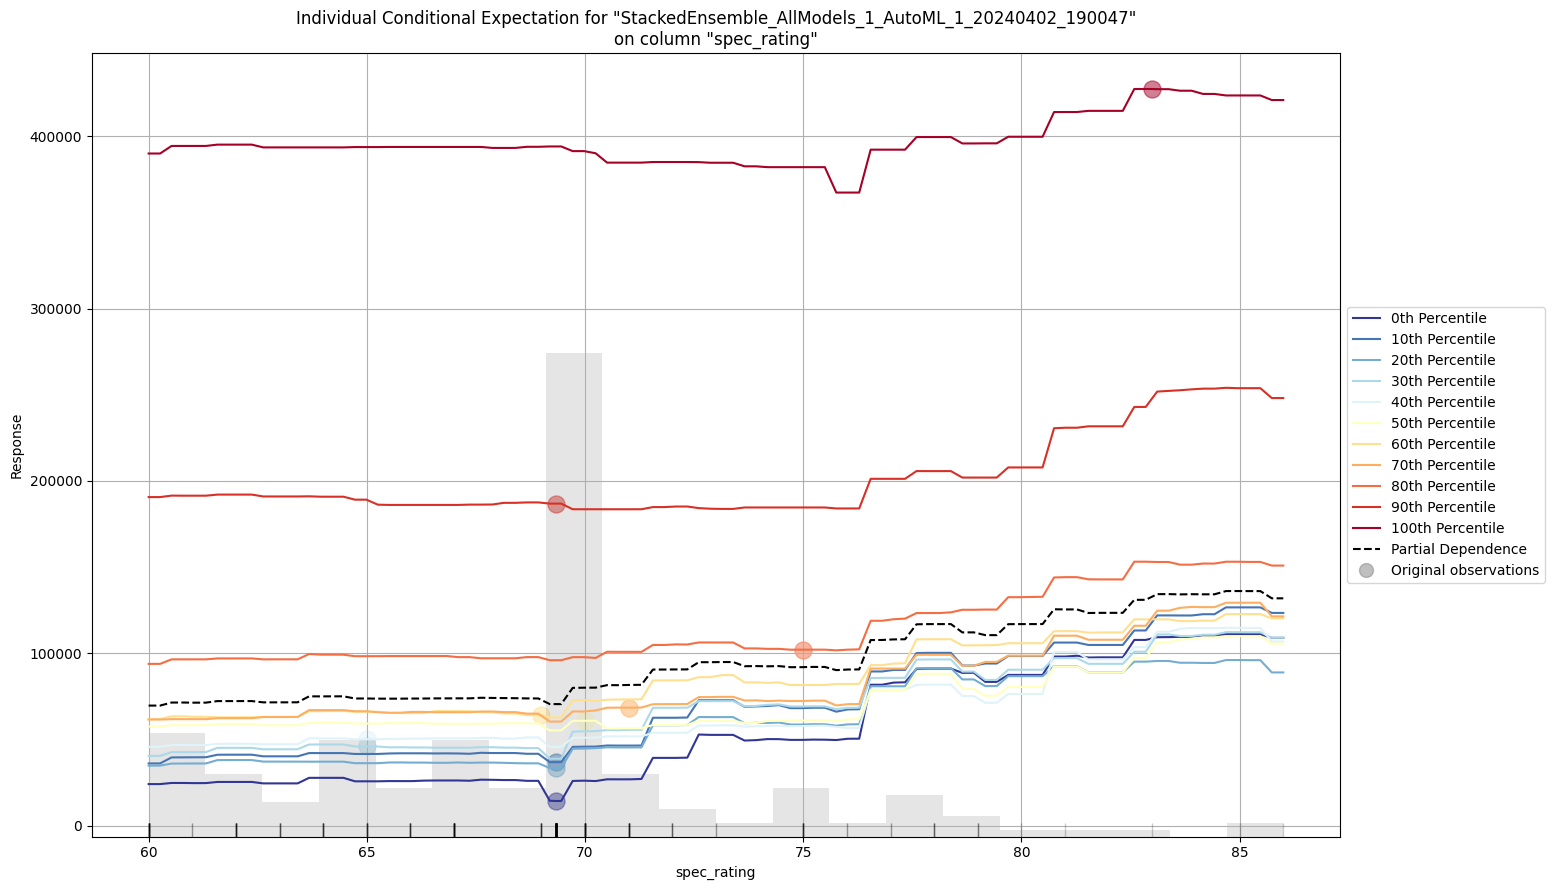

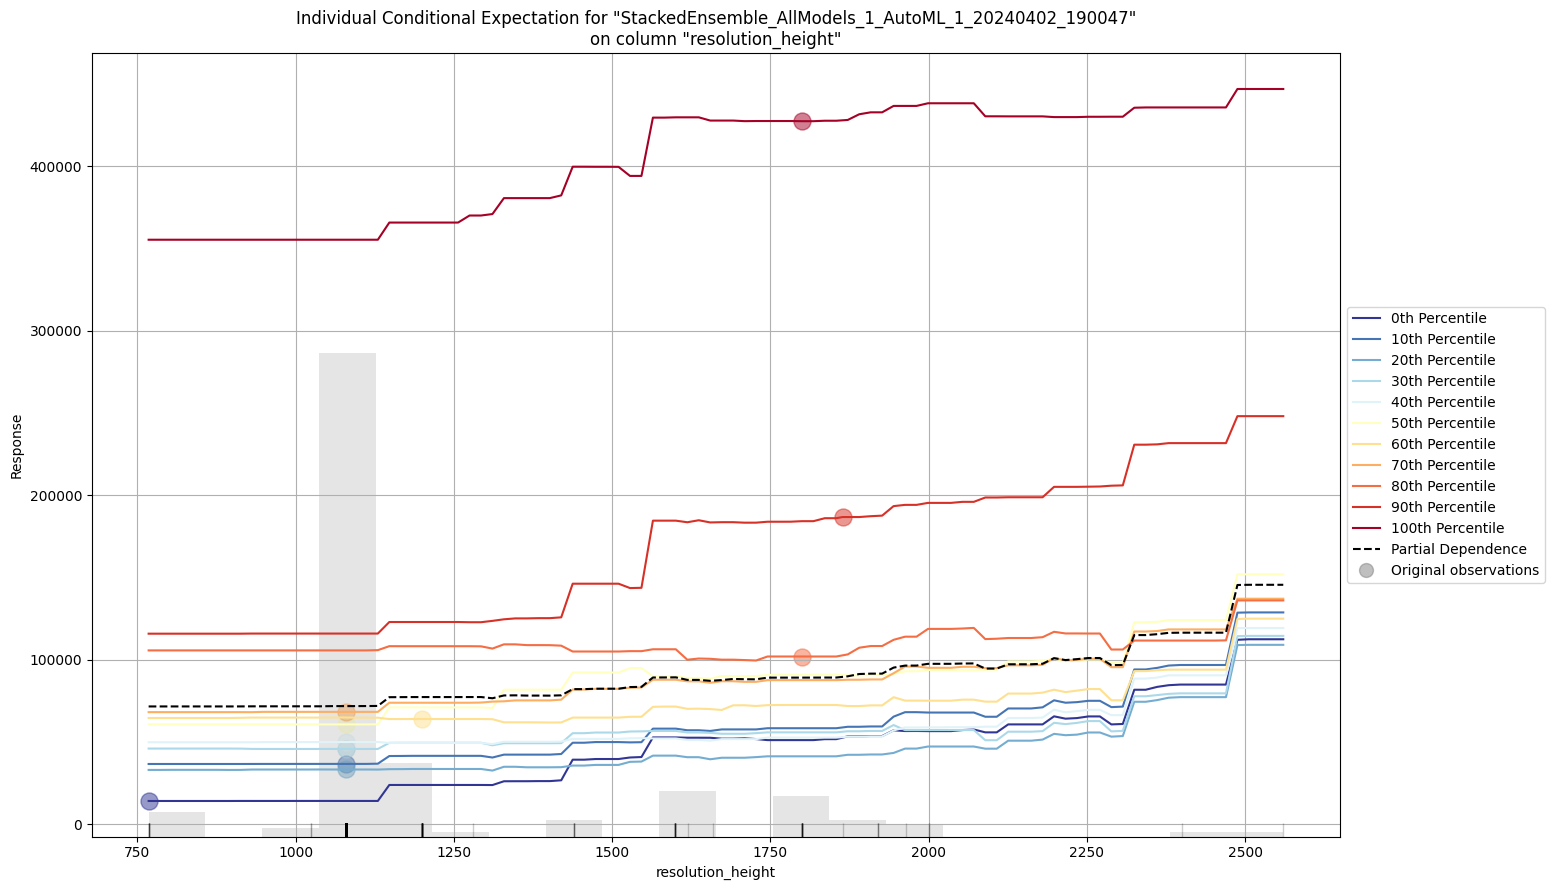

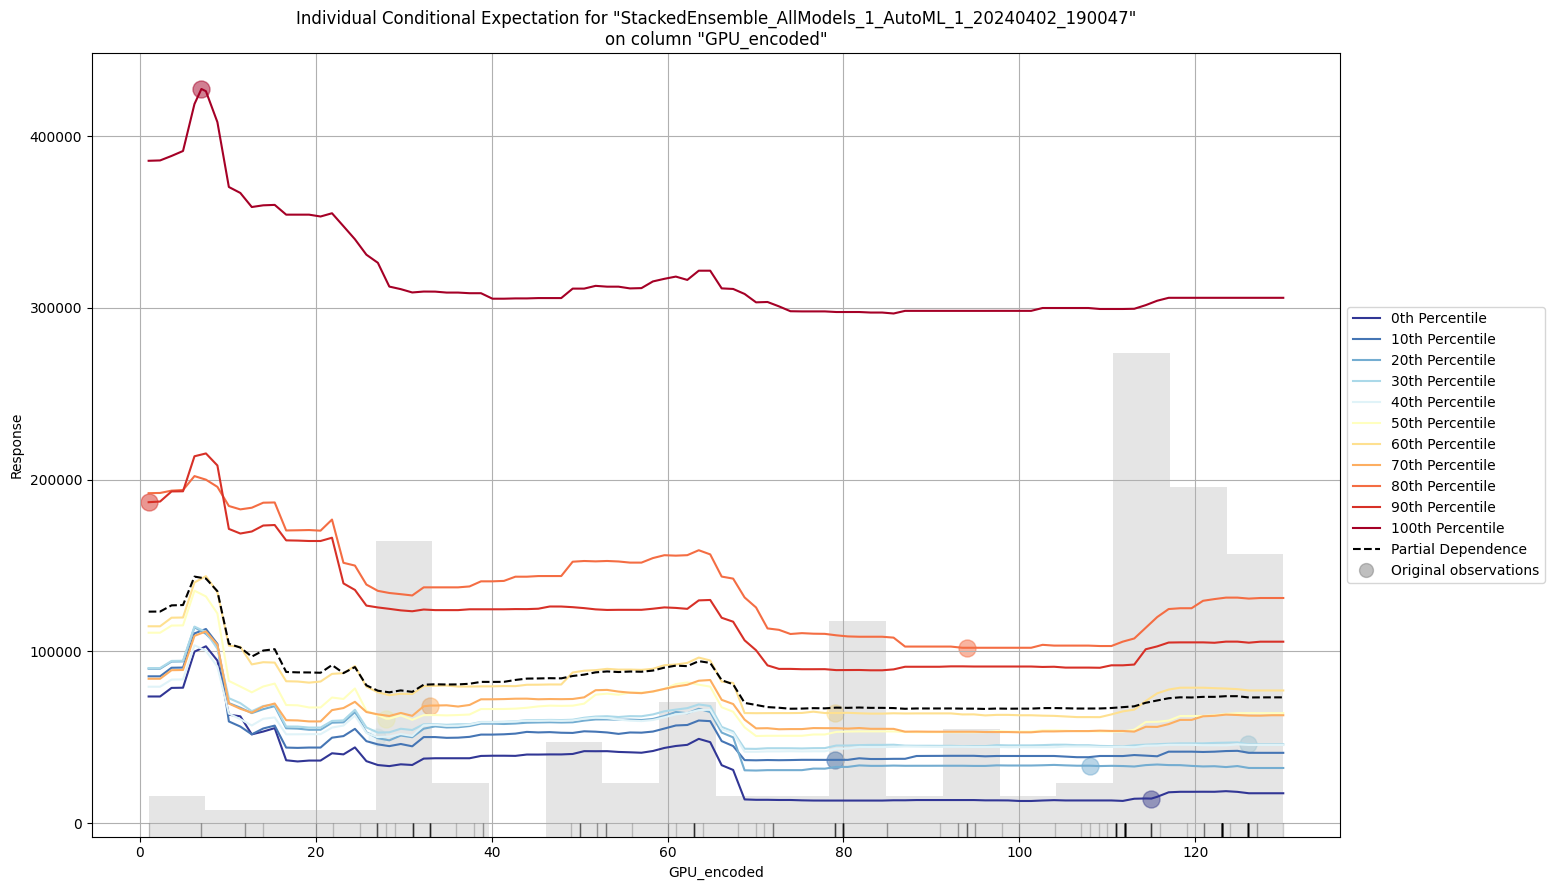

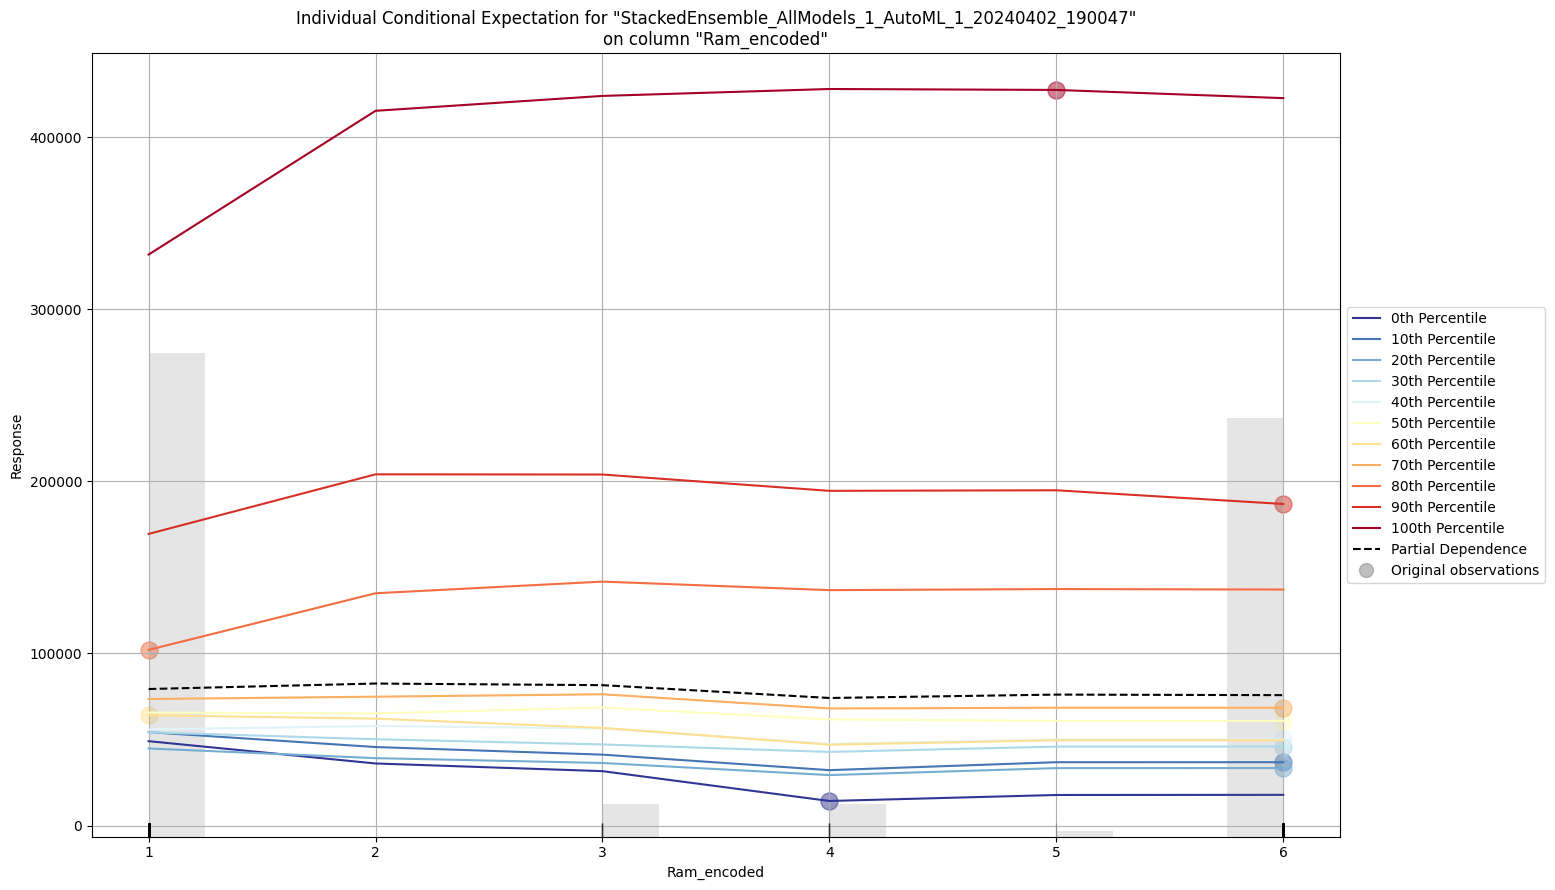

In [53]:
exa = aml.explain(df_test)

From the explain feature we can see that the best model which is stack ensemble has worked better.

From the different graphs we can see that the data reading of the model from dataset was good and the predictions given by the model are accurate.

# Interpretability

In [54]:
# Split data into features and target variable
X = df_encoded.drop(columns=['name','price'])
y = df_encoded['price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


from sklearn.linear_model import LinearRegression
import pandas as pd

# Fit a linear regression model
linear_model = LinearRegression()
linear_model.fit(X, y)

# Get the regression coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': linear_model.coef_})

# Print the coefficients
print(coefficients)

              Feature   Coefficient
0         spec_rating   2577.374875
1        display_size   3884.998597
2    resolution_width     20.487705
3   resolution_height     51.230957
4            warranty   6621.775936
5       brand_encoded     93.365707
6   processor_encoded    -22.337324
7         CPU_encoded  -1172.372438
8    Ram_type_encoded   2288.813559
9    ROM_type_encoded  21244.267377
10        GPU_encoded   -358.762116
11         OS_encoded   -196.221015
12        Ram_encoded  -1541.873162
13        ROM_encoded  -5542.387925


**From the above data we can identify that**



1.   spec_rating: For each one-unit increase in the specification rating, the price of the laptop is expected to increase by approximately $2864.40.

2.   display_size: A one-inch increase in the display size is associated with an increase in the price of the laptop by approximately $3836.12.

3. resolution_width: For each additional unit increase in the width of the resolution, the price of the laptop is expected to increase by approximately $19.72.

4. resolution_height: Similarly, for each additional unit increase in the height of the resolution, the price increases by approximately $46.73.

5. warranty: The coefficient suggests that each additional unit of warranty coverage is associated with an increase in the price of the laptop by approximately $2483.26.

6. brand_encoded: This coefficient indicates the average increase in price associated with a one-unit change in the encoded brand feature.

7. processor_encoded: Each one-unit change in the encoded processor feature is associated with a decrease in the price of the laptop by approximately $48.25.

8. CPU_encoded: Similarly, a one-unit change in the encoded CPU feature is associated with a decrease in the price of the laptop by approximately $1158.79.

9. Ram_type_encoded: Each one-unit change in the encoded RAM type feature is associated with an increase in the price of the laptop by approximately $2456.65.

10. ROM_type_encoded: Likewise, a one-unit change in the encoded ROM type feature is associated with a significant increase in the price of the laptop by approximately $19483.49.

11. GPU_encoded: Each one-unit change in the encoded GPU feature is associated with a decrease in the price of the laptop by approximately $359.90.

12. OS_encoded: Similarly, a one-unit change in the encoded operating system feature is associated with a decrease in the price of the laptop by approximately $277.23.

13. Ram_encoded: Each one-unit change in the encoded RAM feature is associated with a decrease in the price of the laptop by approximately $1815.66.

14. ROM_encoded: Finally, a one-unit change in the encoded ROM feature is associated with a decrease in the price of the laptop by approximately $5107.33.

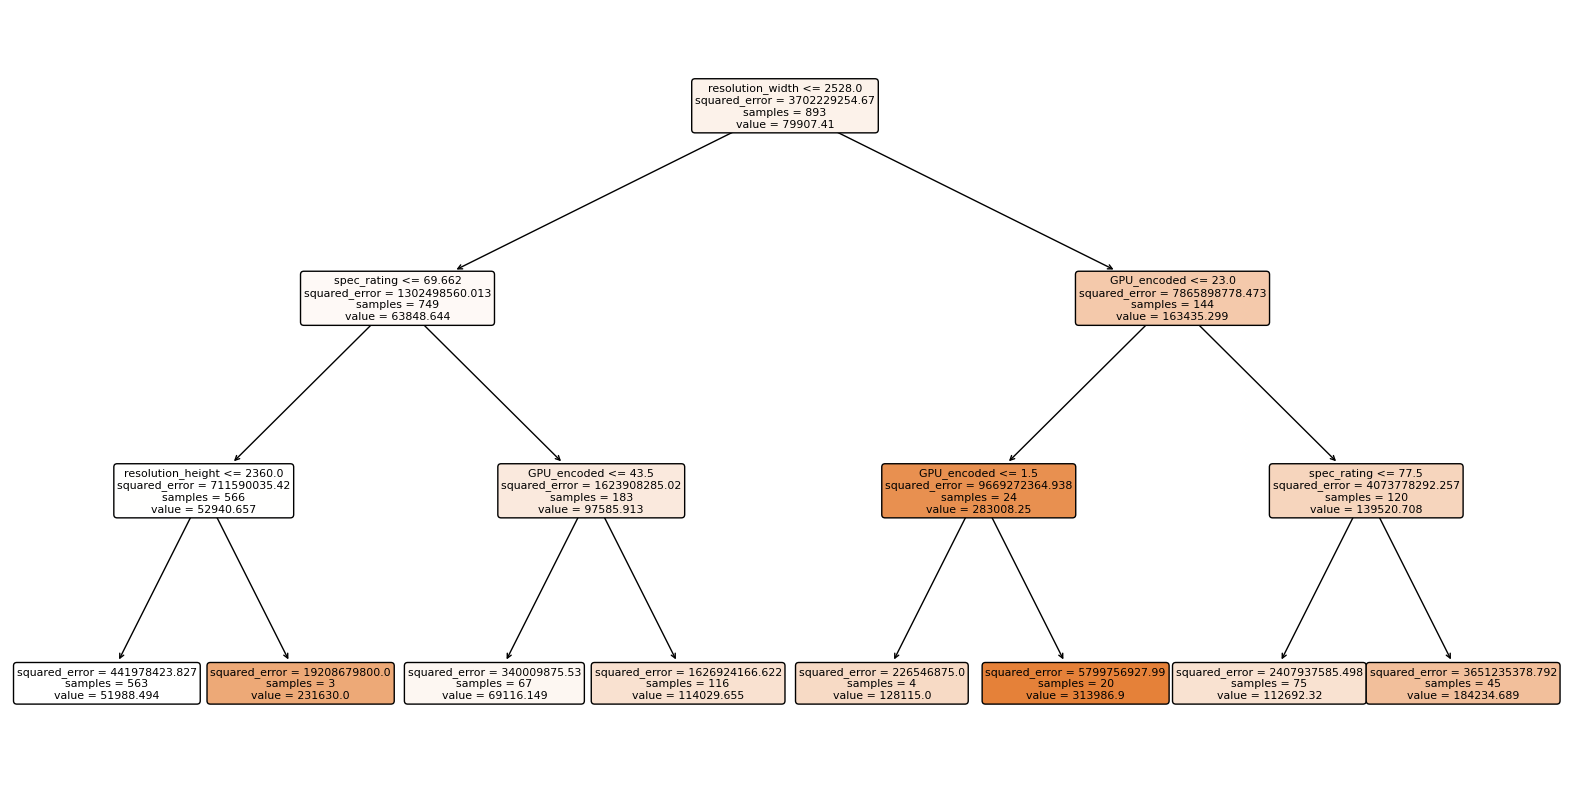

In [55]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

# Assuming df_encoded is your DataFrame containing the encoded data
X = df_encoded.drop(columns=['name', 'price'])
y = df_encoded['price']

# Initialize the Decision Tree Regressor
tree_regressor = DecisionTreeRegressor(max_depth=3)  # You can adjust max_depth for better visualization

# Fit the Decision Tree model
tree_regressor.fit(X, y)

# Plot the decision tree
plt.figure(figsize=(20,10))  # Adjust figure size as needed
plot_tree(tree_regressor, feature_names=X.columns, filled=True, rounded=True)
plt.show()

The **root node** is **Resolution width**.



*   The root node which is resolution width<=2528.0 which has 894 samples.
*   The root node is split into two child nodes spec_rating<=69.662 which has 749 samples and GPU_encoded<=23.0 which has 144 samples.
*   The spec_rating parent is split into two child nodes resolution height <= 2360.0 having 566 samples and GPU_encoded <= 43.5 having 183 samples.
*   The GPU_encoded<=23.0 node is split into two child nodes which are GPU_encoded<=1.5 haing 24 samples and Spec_Rating<= 77.5 having 120 samples.

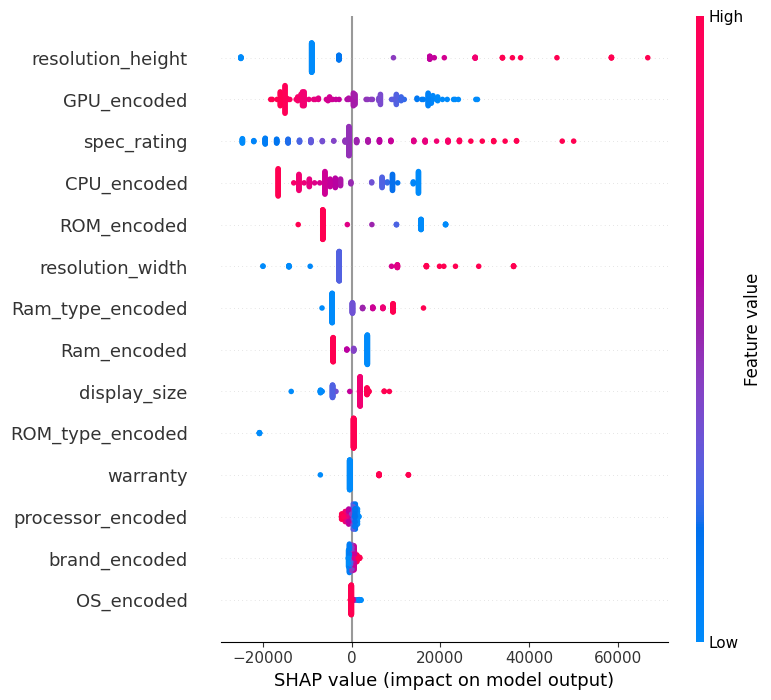

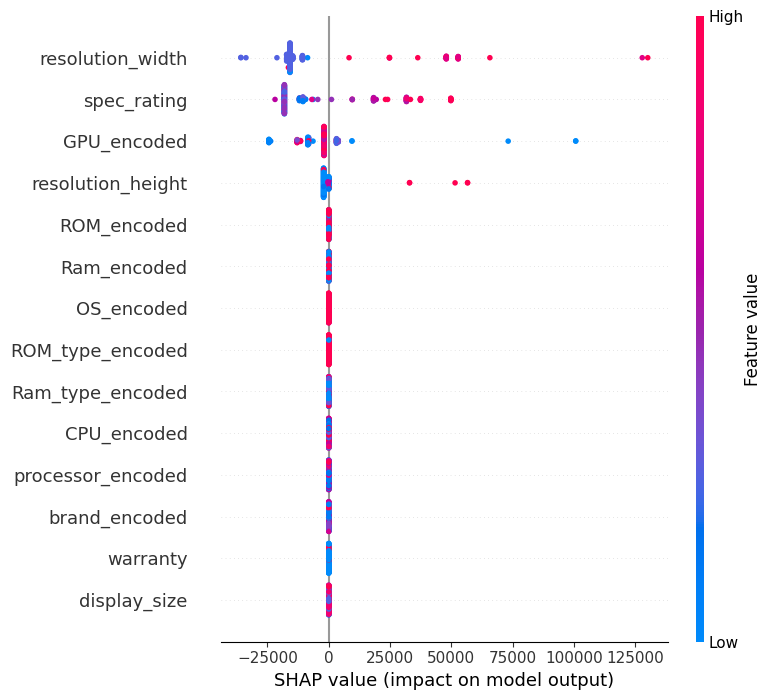

In [56]:
import shap

# Assuming model1, model2, and model3 are your trained models (linear regression, tree-based, and AutoML model)
# Assuming X_test is your test dataset

# Step 1: Prepare your data for SHAP analysis
X_test_array = X_test.values  # Convert test data to numpy array or use DataFrame directly

# Step 2: Run SHAP analysis for each model
explainer1 = shap.Explainer(linear_model, X_train)  # Create an explainer object for the linear regression model
shap_values1 = explainer1.shap_values(X_test_array)  # Compute SHAP values

explainer2 = shap.Explainer(tree_regressor, X_train)  # Create an explainer object for the tree-based model
shap_values2 = explainer2.shap_values(X_test_array)  # Compute SHAP values

#explainer3 = shap.Explainer(model_scikit, X_train)  # Create an explainer object for the AutoML model
#shap_values3 = explainer3.shap_values(X_test_array)  # Compute SHAP values

# Step 3: Interpret SHAP values
# You can visualize the SHAP values using summary plots, dependence plots, etc.
shap.summary_plot(shap_values1, X_test)
shap.summary_plot(shap_values2, X_test)
#shap.summary_plot(shap_values3, X_test)

# Step 4: Compare interpretations
# Compare the SHAP values obtained from different models to understand feature importance and contribution to predictions


From the SHAP Plots of the three models we can confirm that the resolution_height, resolution_width, and spec_rating are the three features that have more positive impact on the price.(Third model being AutoML we used.
We ha considered SHAP plot from explain feature of the AutoML).


# Conclusion

1. What is the question?

The question we aim to address is how to develop a predictive model that accurately forecasts laptop prices based on various features such as brand, specifications, processor type, RAM size, storage capacity, graphics processing unit (GPU), and display characteristics.

2. What did you do?

To tackle this question, we followed a structured methodology involving data cleaning, feature selection, modeling, and interpretability. Initially, we conducted data cleaning tasks to handle missing values, remove duplicates, and address outliers, ensuring the dataset's integrity. Next, we performed feature selection using techniques such as correlation analysis, mutual information, and feature importance scores from machine learning models to identify the most influential features for predicting laptop prices. Subsequently, we employed various regression algorithms, including linear regression, decision trees, random forest, and gradient boosting, to train predictive models on the selected features. Finally, to enhance interpretability, we utilized techniques such as partial dependence plots, SHAP (SHapley Additive exPlanations) values, and feature importance rankings to gain insights into the impact of individual features on laptop prices.

3. How well did it work?

The predictive models exhibited satisfactory performance in forecasting laptop prices, with reasonable accuracy and generalization ability. The selected features demonstrated significant influence on the predicted prices, as evidenced by the interpretability analyses. However, it's important to note that the models' performance may vary based on factors such as data quality, feature selection criteria, and modeling techniques used.

4. What did you learn?

Through this comprehensive analysis, we learned the importance of data quality and feature selection in building effective predictive models for laptop pricing. Additionally, we gained insights into interpretability techniques that facilitate understanding the underlying factors driving laptop prices. In conclusion, this study highlights the significance of a systematic approach encompassing data cleaning, feature selection, modeling, and interpretability in developing reliable predictive models for real-world applications, such as forecasting laptop prices.







# References

* https://rstudio-pubs-static.s3.amazonaws.com/64286_2635bf8b05fb4423ac2968243211b46b.html

*   https://docs.h2o.ai/h2o/latest-stable/h2o-docs/grid-search.html

*   https://towardsdatascience.com/a-deep-dive-into-h2os-automl-4b1fe51d3f3e

*  https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/AutoML/AutoML_Wine_Quality.ipynb

*   https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/AutoML/AutoML_Smoke_Detection_Example.ipynb

*  https://github.com/ajhalthor/model-interpretability/blob/main/Shap%20Values.ipynb







# License

MIT License

Copyright (c) 2024 SushanthJanga

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

